# **High Value Customer Identification - Notebook A** 

Context
Typically e-commerce datasets are proprietary and consequently hard to find among publicly available data. However, The UCI Machine Learning Repository has made this dataset containing actual transactions from 2010 and 2011. The dataset is maintained on their site, where it can be found by the title "Online Retail".

Content
"This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers."

**Tópicos neste notebook:**

1 - Data Description

2 - Feature Engineering

3 - Filtragem de Variáveis

# Planejamento da Solução (IOT)

## Input - Entrada

1. Problema de negócio: selecionar os mais valiosos clientes para formar o programa de fidelidade **"INSIDERS"**
2. Conjunto de dados com as vendas de produtos durante 1 ano ( Dez 2010 to Dez 2011)

## Output - Saída

1. A indicação de pessoas para fazer parte do programa de fidelidade **"INSIDERS"**.

2. Relatório com as respostas para as seguintes perguntas:
    - Quem são as pessoas elegíveis para participar do programa de Insiders ?
    - Quantos clientes farão parte do grupo?
    - Quais as principais características desses clientes ?
    - Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
    - Qual a expectativa de faturamento desse grupo para os próximos meses ?
    - Quais as condições para uma pessoa ser elegível ao Insiders ?
    - Quais as condições para uma pessoa ser removida do Insiders ?
    - Qual a garantia que o programa Insiders é melhor que o restante da base ?
    - Quais ações o time de marketing pode realizar para aumentar o faturamento?

## Tasks - Processo

1. **Quem são as pessoas elegíveis para participar do programa de Insiders ?**
    - O que é ser elegível ? O que é um cliente "valioso" para a empresa ?
        - Faturamento:
            - Alto Ticket Médio
            - Alto LTV
            - Baixa Recência ou Alta Frequência ( tempo entre as compras )
            - Alto Basket Size ( quantidade média de produtos comprados )
            - Baixa probabilidade de Churn
            - Previsão alta de LTV
            - Alta propensão de compra

        - Custo:
            - Baixo número de devoluções

        - Experiência:  
            - Média alta de avaliações
            
            
2. **Quantos clientes farão parte do grupo?**
    - Número de clientes
    - % em relação ao total de clients
    
    
3. **Quais as principais características desses clientes ?**
    - Escrever os principais atributos dos clientes
        - Idade
        - País
        - Salário
        
    - Escrever os principais comportamentos de compra dos clients ( métricas de negócio )
        - Vide acima
    
    
4. **Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?**
    - Calcular o faturamento total da empresa durante o ano.
    - Calcular o faturamento (%) apenas do cluster Insiders.
    
    
5. **Qual a expectativa de faturamento desse grupo para os próximos meses ?**
    - Cálculo do LTV do grupo Insiders
    - Séries Temporais ( ARMA, ARIMA, HoltWinter, etc )
    

6. **Quais as condições para uma pessoa ser elegível ao Insiders ?**
    - Qual o período de avaliação ?
    - O "desempenho" do cliente está próximo da média do cluster Insiders. 
    
    
7. **Quais as condições para uma pessoa ser removida do Insiders ?**
    - O "desempenho" do cliente não está mais próximo da média do cluster Insiders. 
    
    
8. **Qual a garantia que o programa Insiders é melhor que o restante da base ?**
    - Teste de Hipóteses
    - Teste A/B
    
    
9. **Quais ações o time de marketing pode realizar para aumentar o faturamento?**
    - Descontos
    - Preferências de escolha
    - Produtos exclusivos

# 0.0 Imports

In [1]:
import pandas as pd
import numpy as np
import math
import re
import sweetviz as sv
import inflection
import seaborn as sns
import umap as umap

from unidecode                  import unidecode
from IPython.display            import Image, display
from matplotlib                 import pyplot as plt 
from plotly                     import express as px
from sklearn                    import cluster as c
from sklearn                    import metrics as m 
from sklearn                    import preprocessing as pp
from sklearn                    import decomposition as dd
from yellowbrick.cluster        import KElbowVisualizer, SilhouetteVisualizer

import warnings
warnings.filterwarnings("ignore")

plt.rcParams['figure.figsize'] = [25, 12]

c:\Users\andre\anaconda3\envs\cluster_fidelidade\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 0.1 Helper Function

In [2]:
# Função para separar letras e números (filtrando dataset - produtos comprados (b) e cancelados(c))
def separar_letras_e_numeros(codigo):
    padrao = re.match(r'([A-Za-z]*)(\d*)', codigo)
    
    if padrao:
        letras = padrao.group(1)
        numeros = padrao.group(2)
        return letras, numeros
    else:
        return None, None

# -------------------------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------------------------

# Função para encontrar a média em dias, entre as últimas 3 compras do cliente
def calculo_rca_media_3(dates_list, max_date):

    # Colocando lista em ordem descrescente 
    sorted_dt_list = sorted(dates_list, reverse=True)
    
    # Encontrado o intervalo de tempo entre compras, em dias
    if len(dates_list) == 1:
        c1 = (max_date - sorted_dt_list[0]).days
        return c1
    
    if len(dates_list) == 2:
        c1 = (max_date - sorted_dt_list[0]).days
        c2 = (sorted_dt_list[0] - sorted_dt_list[1]).days
        return (c1+c2) / 2

    if len(dates_list) >= 3:
        c1 = (max_date - sorted_dt_list[0]).days
        c2 = (sorted_dt_list[0] - sorted_dt_list[1]).days
        c3 = (sorted_dt_list[1] - sorted_dt_list[2]).days
        return (c1+c2+c3) / 3

# -------------------------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------------------------

# Função para encontrar a média, em dias, entre a diferença (diff) de todas as datas de compras do cliente
def calculo_rca_media_total(dates_list, max_date):

    # Colocando as datas em ordem decrescente
    sorted_dt_list = sorted(dates_list, reverse=True)

    # Inserindo a última data do dataset em primeiro lugar da lista ordenada
    sorted_dt_list.insert(0, max_date)

    # Calculando a diferença entre cada data
    date_diff_list = [(sorted_dt_list[i] - sorted_dt_list[i - 1]).days for i in range(1, len(sorted_dt_list))]
    
    # Calculando a média de todos os intervalos
    media_rca_total = abs( sum(date_diff_list) / len(date_diff_list) )

    return media_rca_total



# -------------------------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------------------------

# Configurações Gerais
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

## 0.2 Loading data

In [3]:
# Dataset treino
df_raw = pd.read_csv('../datasets/raw_datasets/data.csv', low_memory = False, encoding='ISO-8859-1')

# Removendo coluna vazia, devido ao csv ter vírgulas no final de cada linha
df_raw = df_raw.drop(['Unnamed: 8'], axis=1)

# **1.0 Data Description**

In [4]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [5]:
# Renomeando as colunas usando a função underscore do inflection
df1.columns = [inflection.underscore(col) for col in df1.columns]
df1.columns

Index(['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country'],
      dtype='object')

## 1.2 Data Dimension

In [6]:
# Printando linhas/colunas
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 541909
Number of Cols: 8


## 1.3 Data Types

In [7]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4. Check NA

In [8]:
'''
Existem 3 opções para tratar os NAs

1- Descartar linhas com valores ausentes (NA):
    Vantagem: rápido e fácil.
    Desvantagem (significativa): Pode levar à perda de informações importantes e prejudicar a performance do modelo se o conjunto de dados for pequeno.

2- Utilizar algoritmos de Machine Learning:
    Existem métodos para preencher valores ausentes (NA) que se baseiam no comportamento das colunas.
    Podemos utilizar métodos estatísticos como a média ou mediana, ou algorimos de Machine Learning para prever valores ausentes.
    Essa técnica é útil quando não se tem informações de negócio.

3- Entender a lógica de negócio:
    Compreendendo a lógica de negócio, é possível identificar o motivo dos valores ausentes e estabelecer regras para preenchê-los.  

Utilizarei a opção 3 para preencher os valores faltantes (NA) no próximo tópico.
'''

df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5 Fillout NA

In [9]:
# Preenchendo os NaN com lógica de negócio

# description
df1['description'] = df1['description'].fillna('no_description')

# customer_id
df1 = df1.dropna(subset=['customer_id'])

# Verificação da remoção dos NaN
df1.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

In [10]:
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.00,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.00,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.00,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.00,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.00,United Kingdom


## 1.6 Change Types

In [11]:
# Verificando os tipos de dados novamente após as alterações feitas no tópico 1.5, por boa prática.  
df1.dtypes

# Covertendo
df1['customer_id'] = df1['customer_id'].astype(int)
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'])
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int32
country                 object
dtype: object

O conjunto de dados inclui as seguintes informações:

| Coluna                     | Descrição                                           |
|----------------------------|-----------------------------------------------------|
| Invoice Number             | Identificador único de cada transação.              |
| Stock Code Product         | Código do item.                                    |
| Description Product        | Nome do item.                                      |
| Quantity                   | A quantidade de cada item comprado por transação.  |
| Invoice Date               | O dia em que a transação ocorreu.                   |
| Unit Price                 | Preço do produto por unidade.                      |
| Customer ID                | Identificador único do cliente.                     |
| Country                    | O nome do país onde o cliente reside.               |
| invoice_date_formatted     | Data formatada (dia/mês/ano).                      |
| month                      | Número do mês.                                     |


## 1.7 Minority Changes (map data)

In [12]:
df1 = df1.drop_duplicates()

## 1.8 Descritive Statistics

In [13]:
df1.describe().T

,count,mean,min,25%,50%,75%,max,std
quantity,401603.00,12.18,-80995.00,2.00,5.00,12.00,80995.00,250.28
invoice_date,401603,2017-07-07 22:53:53.288595712,2016-11-29 00:00:00,2017-04-04 00:00:00,2017-07-27 00:00:00,2017-10-18 00:00:00,2017-12-07 00:00:00,NaN
unit_price,401603.00,3.47,0.00,1.25,1.95,3.75,38970.00,69.76
customer_id,401603.00,15281.16,12346.00,13939.00,15145.00,16784.00,18287.00,1714.01


In [14]:
df1[df1['quantity'] == 80995]
df1[df1['quantity'] == -80995]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2017-12-07,2.08,16446,United Kingdom


## 1.9 Pandas profile

# **2.0 Data Filtering**

In [15]:
df2 = df1.copy()

In [16]:
# Condiderando comprar apenas acima de 0,04 porque 
df2 = df2[df2['unit_price'] >= 0.04]

# Removendo compras das seguintes regiões, por terem valor irrelevante 
df2 = df2[~df2['country'].isin(['European Community', 'Unspecified'])]

# Filtrando dataset: menor que 0 (devoluções) e maior que 0 (compras)
# Nota: identifiquei que o código do retorno de um pedido, além de iniciar com a letra C, tem o código diferente.
df2_returns = df2.loc[df1['quantity'] < 0, :]
df2_purchases = df2.loc[df1['quantity'] >= 0, :]
prct_cancel = round(df2_returns.shape[0] / df2.shape[0], 2) * 100
print(f'Os cancelamentos representam {prct_cancel}% do total de vendas')

# DEIXAR PARA REMOVER ISSO APENAS QUANDO FOR APLICAR O ENCODIGNS E TALZS
# # description -----
# df2 = df2.drop(columns='description', axis=1)
# # === Categorical attributes ====
# df2 = df2[~df2['stock_code'].isin( ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL','PADS', 'B', 'CRUK'] )]

Os cancelamentos representam 2.0% do total de vendas


# **3.0 Feature Engineering**

In [17]:
df3 = df2_purchases.copy()

1. peso para compras mais recorrente
    - ultima
    - penultima .shift(1)
    - antepenultima compras .shift(2) OK OK OK

2. qtde_invoices OK
5. Avg_ticket OK
8. number of returns OK

3. qtde_items ( Total de itens que um cliente comprou, não importa se é o mesmo produto ou não)

4. qtde_produtos ( total de itens unicos que um cliente comprou)

6. avg_recency_days (FAZER MÉDIA DAS 3?)

7. frequency

9. basket size

10. unique basket size

11. Groos revenue return

12. proporção de retorno sobre compra


## 3.1 Faturamento

In [18]:
# Faturamento por linha 
df3['faturamento'] = df3['quantity'] * df3['unit_price']

## 3.2 Valor total das compras & Total de transações (ambos por cliente)

In [19]:
# Valor total das compras & Total de transações (ambos por cliente)
fatur_cliente = df3.groupby('customer_id').agg({ 'faturamento': 'sum', 'invoice_no':'nunique'}).reset_index()
fatur_cliente.columns = ['customer_id', 'total_valor', 'total_transacoes']

# Nota: nunique aqui, pois os invoice_no se repetem devido cada linha do dataset ser um produto, ou seja, ele pode ter feito uma compra mas com vários produtos
# então aparecerá vários invoice_no repetidos.

## 3.3 Ticket Médio 

In [20]:
# Ticket médio
fatur_cliente['ticket_medio'] = fatur_cliente['total_valor'] / fatur_cliente['total_transacoes']
fatur_cliente

,customer_id,total_valor,total_transacoes,ticket_medio
0,12346,77183.60,1,77183.60
1,12347,4310.00,7,615.71
2,12348,1797.24,4,449.31
3,12349,1757.55,1,1757.55
4,12350,334.40,1,334.40
...,...,...,...,...
4328,18280,180.60,1,180.60
4329,18281,80.82,1,80.82
4330,18282,178.05,2,89.03
4331,18283,2045.53,16,127.85


## 3.4 Recencias

- RECÊNCIA em dias, da última compra:

In [21]:
# RECÊNCIA em dias, da última compra:

# Data da última compra de cada cliente
rca_ultima_compra = df3.loc[:, ['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
# Renomeando colunas
rca_ultima_compra.rename(columns={'invoice_date': 'ultima_compra'}, inplace=True)

# Data maxima do dataset df3 inteiro
rca_ultima_compra['data_max'] = df3['invoice_date'].max()
# Encontrando em dias, a diferença do ultimo dia de compra do cliente com a data max do dataset
rca_ultima_compra['recencia_ultima_compra'] = (rca_ultima_compra['data_max'] - rca_ultima_compra['ultima_compra']).dt.days
rca_ultima_compra

,customer_id,ultima_compra,data_max,recencia_ultima_compra
0,12346,2017-01-16,2017-12-07,325
1,12347,2017-12-05,2017-12-07,2
2,12348,2017-09-23,2017-12-07,75
3,12349,2017-11-19,2017-12-07,18
4,12350,2017-01-31,2017-12-07,310
...,...,...,...,...
4328,18280,2017-03-05,2017-12-07,277
4329,18281,2017-06-10,2017-12-07,180
4330,18282,2017-11-30,2017-12-07,7
4331,18283,2017-12-04,2017-12-07,3


- RECÊNCIA média, em dias, das 3 últimas compras:

In [22]:
# RECÊNCIA média, em dias, das 3 últimas compras:

# Agrupando todos os chamados de cada cliente e utilizando o set para pegar apenas uma data unica, estava
# repetindo as datas, pois cada linha do dataset é um produto, se o cliente comprou mais de um produto no 
# mesmo dia resultava em várias datas iguais na coluna invoice_date com código de transação invoice_no repetido
rca_media_3 = df3.groupby('customer_id')['invoice_date'].agg(lambda x: list(set(x))).reset_index()
rca_media_3.columns = ['customer_id', 'unique_invoice_dates']
rca_media_3

# Data maxima do dataset df3 inteiro
max_date = df3['invoice_date'].max()
# Encontrando em dias, a diferença dos 3 últimos dias de compra do cliente com a data max do dataset
rca_media_3['recencia_media_3'] = rca_media_3['unique_invoice_dates'].apply(calculo_rca_media_3, args=(max_date,))
rca_media_3

,customer_id,unique_invoice_dates,recencia_media_3
0,12346,[2017-01-16 00:00:00],325.00
1,12347,"[2017-12-05 00:00:00, 2017-10-29 00:00:00, 201...",43.00
2,12348,"[2017-09-23 00:00:00, 2017-04-03 00:00:00, 201...",106.00
3,12349,[2017-11-19 00:00:00],18.00
4,12350,[2017-01-31 00:00:00],310.00
...,...,...,...
4328,18280,[2017-03-05 00:00:00],277.00
4329,18281,[2017-06-10 00:00:00],180.00
4330,18282,"[2017-11-30 00:00:00, 2017-08-03 00:00:00]",63.00
4331,18283,"[2017-01-04 00:00:00, 2017-02-26 00:00:00, 201...",5.33


- RECÊNCIA média, em dias, de todas as compras:

In [23]:
# RECÊNCIA média, em dias, de todas as compras:

# Agrupando todos os chamados de cada cliente e utilizando o set para pegar apenas uma data unica, estava
# repetindo as datas, pois cada linha do dataset é um produto, se o cliente comprou mais de um produto no 
# mesmo dia resultava em várias datas iguais na coluna invoice_date com código de transação invoice_no repetido
rca_total_media = df3.groupby('customer_id')['invoice_date'].agg(lambda x: list(set(x))).reset_index()

# Renomeando colunas
rca_total_media.columns = ['customer_id', 'unique_invoice_dates']

# Recencia Média em dias das 3 ultimas compras de cada cliente
max_date = df3['invoice_date'].max()
rca_total_media['rencencia_media_total'] = rca_total_media['unique_invoice_dates'].apply(calculo_rca_media_total, args=(max_date,))
rca_total_media

,customer_id,unique_invoice_dates,rencencia_media_total
0,12346,[2017-01-16 00:00:00],325.00
1,12347,"[2017-12-05 00:00:00, 2017-10-29 00:00:00, 201...",52.43
2,12348,"[2017-09-23 00:00:00, 2017-04-03 00:00:00, 201...",89.50
3,12349,[2017-11-19 00:00:00],18.00
4,12350,[2017-01-31 00:00:00],310.00
...,...,...,...
4328,18280,[2017-03-05 00:00:00],277.00
4329,18281,[2017-06-10 00:00:00],180.00
4330,18282,"[2017-11-30 00:00:00, 2017-08-03 00:00:00]",63.00
4331,18283,"[2017-01-04 00:00:00, 2017-02-26 00:00:00, 201...",24.07


## 3.5 Cancelamentos por cliente

In [24]:
total_c = df2_returns.loc[:, ['customer_id', 'invoice_no']].groupby('customer_id').nunique().reset_index()
total_c.columns = ['customer_id', 'qnt_cancel']
total_c

,customer_id,qnt_cancel
0,12346,1
1,12352,3
2,12359,2
3,12362,3
4,12365,1
...,...,...
1583,18272,1
1584,18274,1
1585,18276,2
1586,18277,1


## 3.6 Merging datasets

In [25]:
# Dropando colunas desnecessárias para o merge
rca_ultima_compra = rca_ultima_compra.drop(['ultima_compra', 'data_max'], axis=1)
rca_media_3 = rca_media_3.drop(['unique_invoice_dates'], axis=1)
rca_total_media = rca_total_media.drop(['unique_invoice_dates'], axis=1)

# Merging 
df3_merged = pd.merge(fatur_cliente, rca_ultima_compra, on='customer_id', how='left')
df3_merged = pd.merge(df3_merged, rca_media_3, on='customer_id', how='left')
df3_merged = pd.merge(df3_merged, rca_total_media, on='customer_id', how='left')
df3_merged = pd.merge(df3_merged, total_c, on='customer_id', how='left').fillna(0)
df3_merged

,customer_id,total_valor,total_transacoes,ticket_medio,recencia_ultima_compra,recencia_media_3,rencencia_media_total,qnt_cancel
0,12346,77183.60,1,77183.60,325,325.00,325.00,1.00
1,12347,4310.00,7,615.71,2,43.00,52.43,0.00
2,12348,1797.24,4,449.31,75,106.00,89.50,0.00
3,12349,1757.55,1,1757.55,18,18.00,18.00,0.00
4,12350,334.40,1,334.40,310,310.00,310.00,0.00
...,...,...,...,...,...,...,...,...
4328,18280,180.60,1,180.60,277,277.00,277.00,0.00
4329,18281,80.82,1,80.82,180,180.00,180.00,0.00
4330,18282,178.05,2,89.03,7,63.00,63.00,1.00
4331,18283,2045.53,16,127.85,3,5.33,24.07,0.00


## 3.7 Ajustando features

In [26]:
# Colunas para inverter (elevadas a -1) para que, por exemplo, quanto mais cancelamentos, ter um peso menor do que maior.
colunas_inverter = ['recencia_ultima_compra', 'recencia_media_3', 'rencencia_media_total', 'qnt_cancel']

# Aplica a função lambda a todas as colunas especificadas
df3_merged[colunas_inverter] = df3_merged[colunas_inverter].applymap(lambda x: 1/x if x != 0 else 0)
df3_merged

,customer_id,total_valor,total_transacoes,ticket_medio,recencia_ultima_compra,recencia_media_3,rencencia_media_total,qnt_cancel
0,12346,77183.60,1,77183.60,0.00,0.00,0.00,1.00
1,12347,4310.00,7,615.71,0.50,0.02,0.02,0.00
2,12348,1797.24,4,449.31,0.01,0.01,0.01,0.00
3,12349,1757.55,1,1757.55,0.06,0.06,0.06,0.00
4,12350,334.40,1,334.40,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...
4328,18280,180.60,1,180.60,0.00,0.00,0.00,0.00
4329,18281,80.82,1,80.82,0.01,0.01,0.01,0.00
4330,18282,178.05,2,89.03,0.14,0.02,0.02,1.00
4331,18283,2045.53,16,127.85,0.33,0.19,0.04,0.00


# **4.0 EDA**

In [27]:
df4 = df3_merged.copy()

## 4.1 Univariate Analysis

**Metricas para olharmos**
1. Clusters Coesos - Separados
2. Métricas
    - Min, Máximo, Range ( Dispersão )
    - Média e Mediana
    - Desvio Padrão e Variância.
    - Coeficiente de Variação ( CV )
    - Distribuição

In [28]:
# # sweeviz OU PROFILE PANDAS 
# report = sv.analyze(df4)
# report.show_html()

## 4.2 Bivariate Analysis

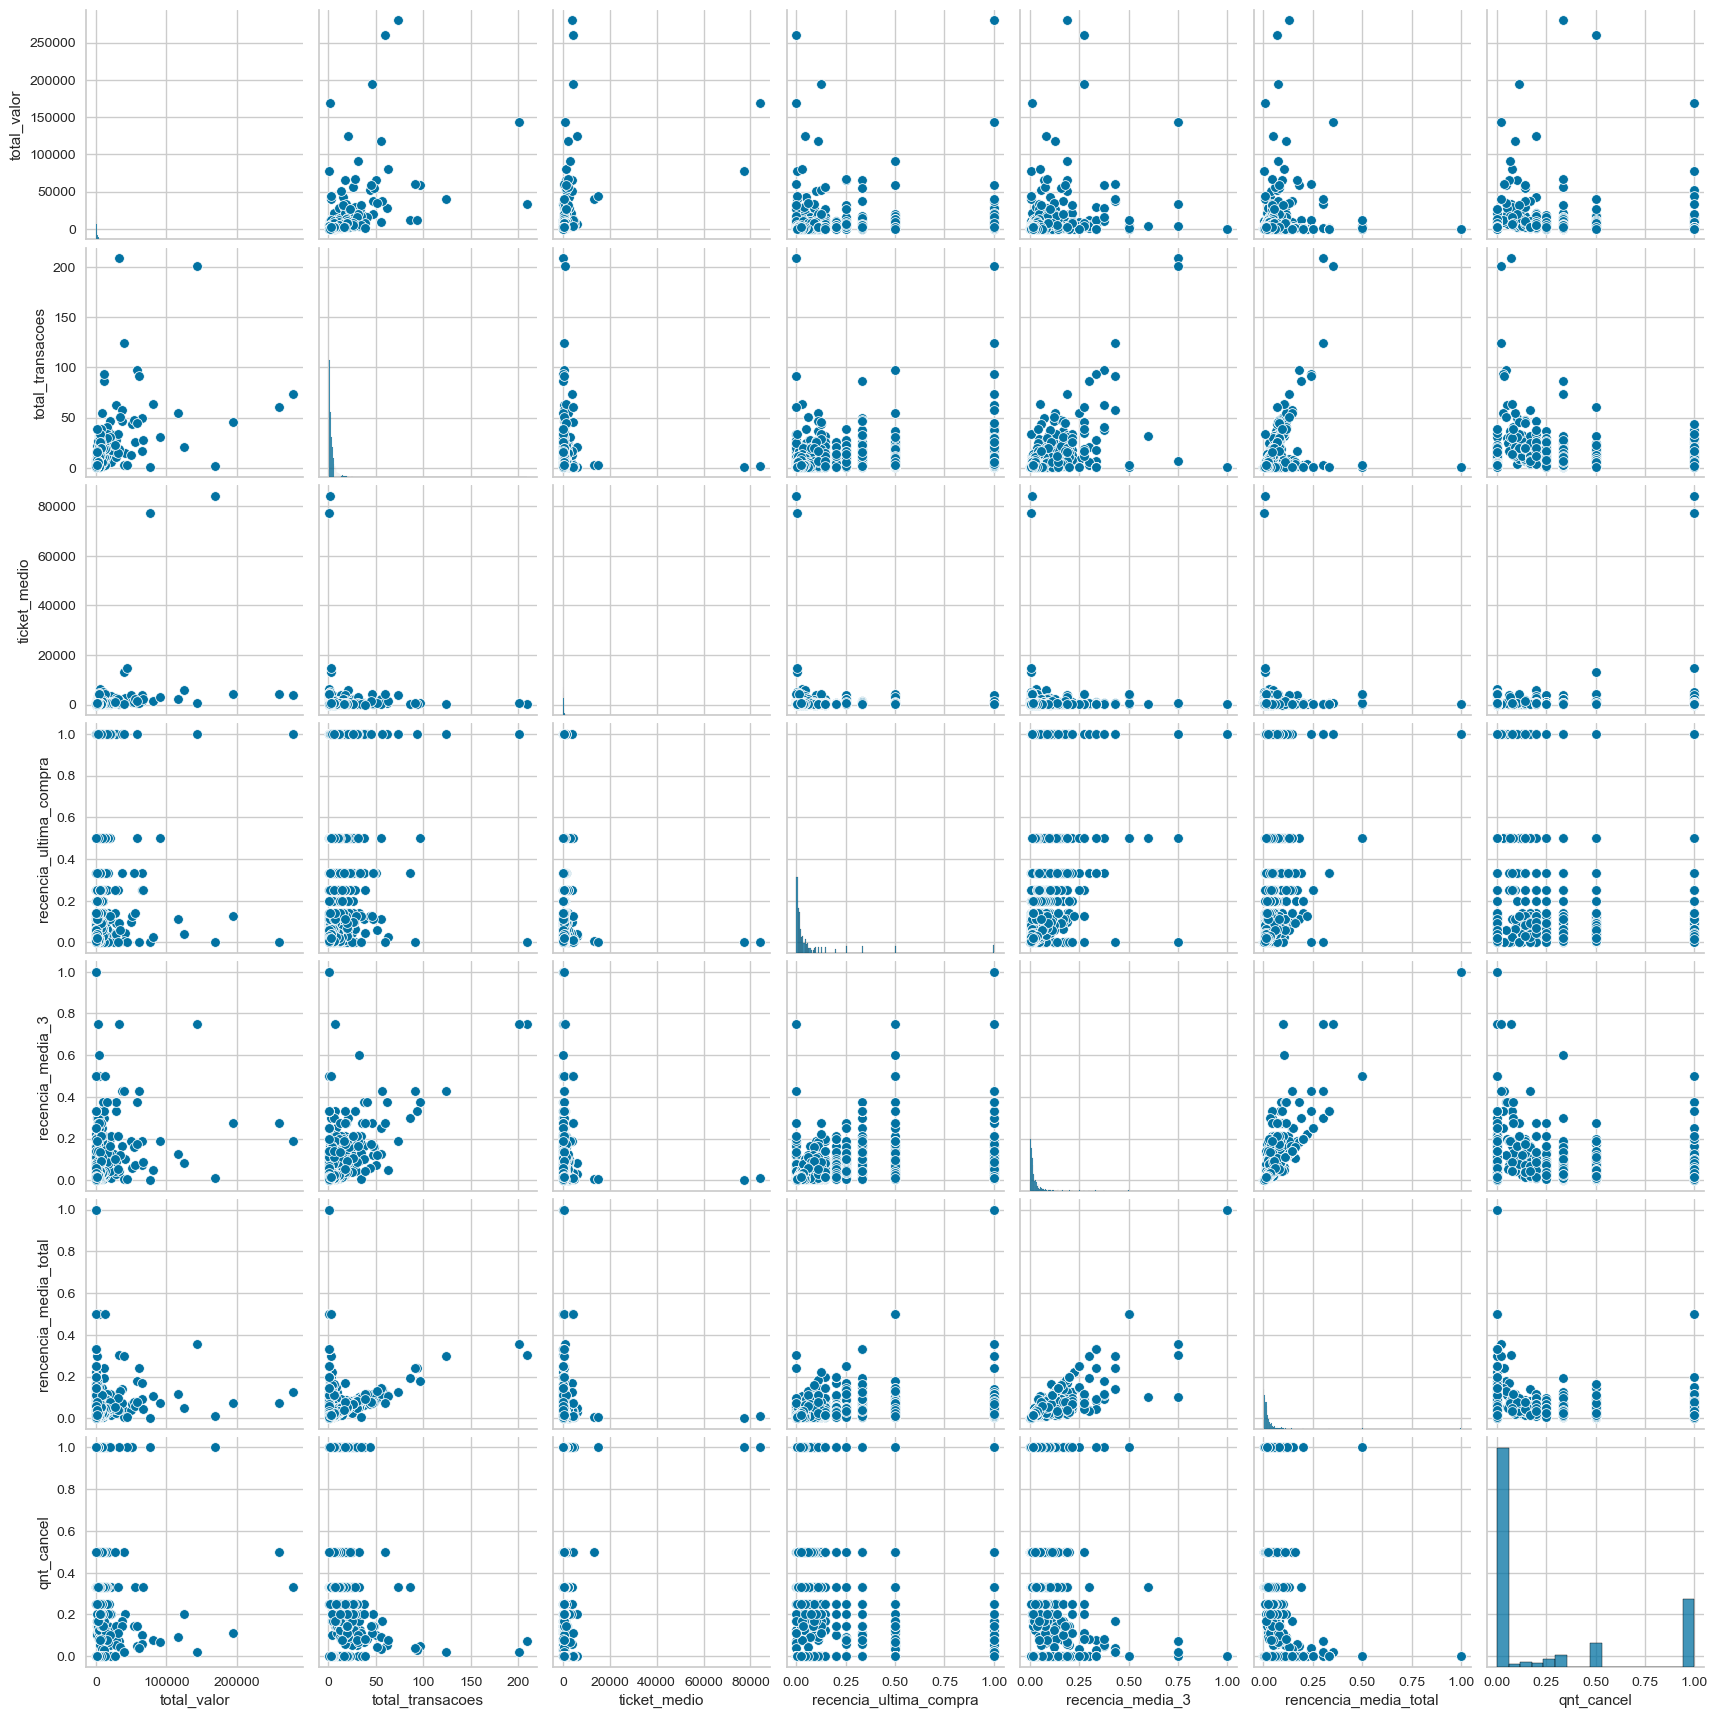

In [29]:
df_bivan = df4.drop(columns=['customer_id'], axis=1)
sns.pairplot(df_bivan)

## 4.3 Estudo de Espaços

In [30]:
df_spaces = df4.drop(columns=['customer_id'], axis=1).copy()

<Axes: xlabel='qnt_cancel', ylabel='Count'>

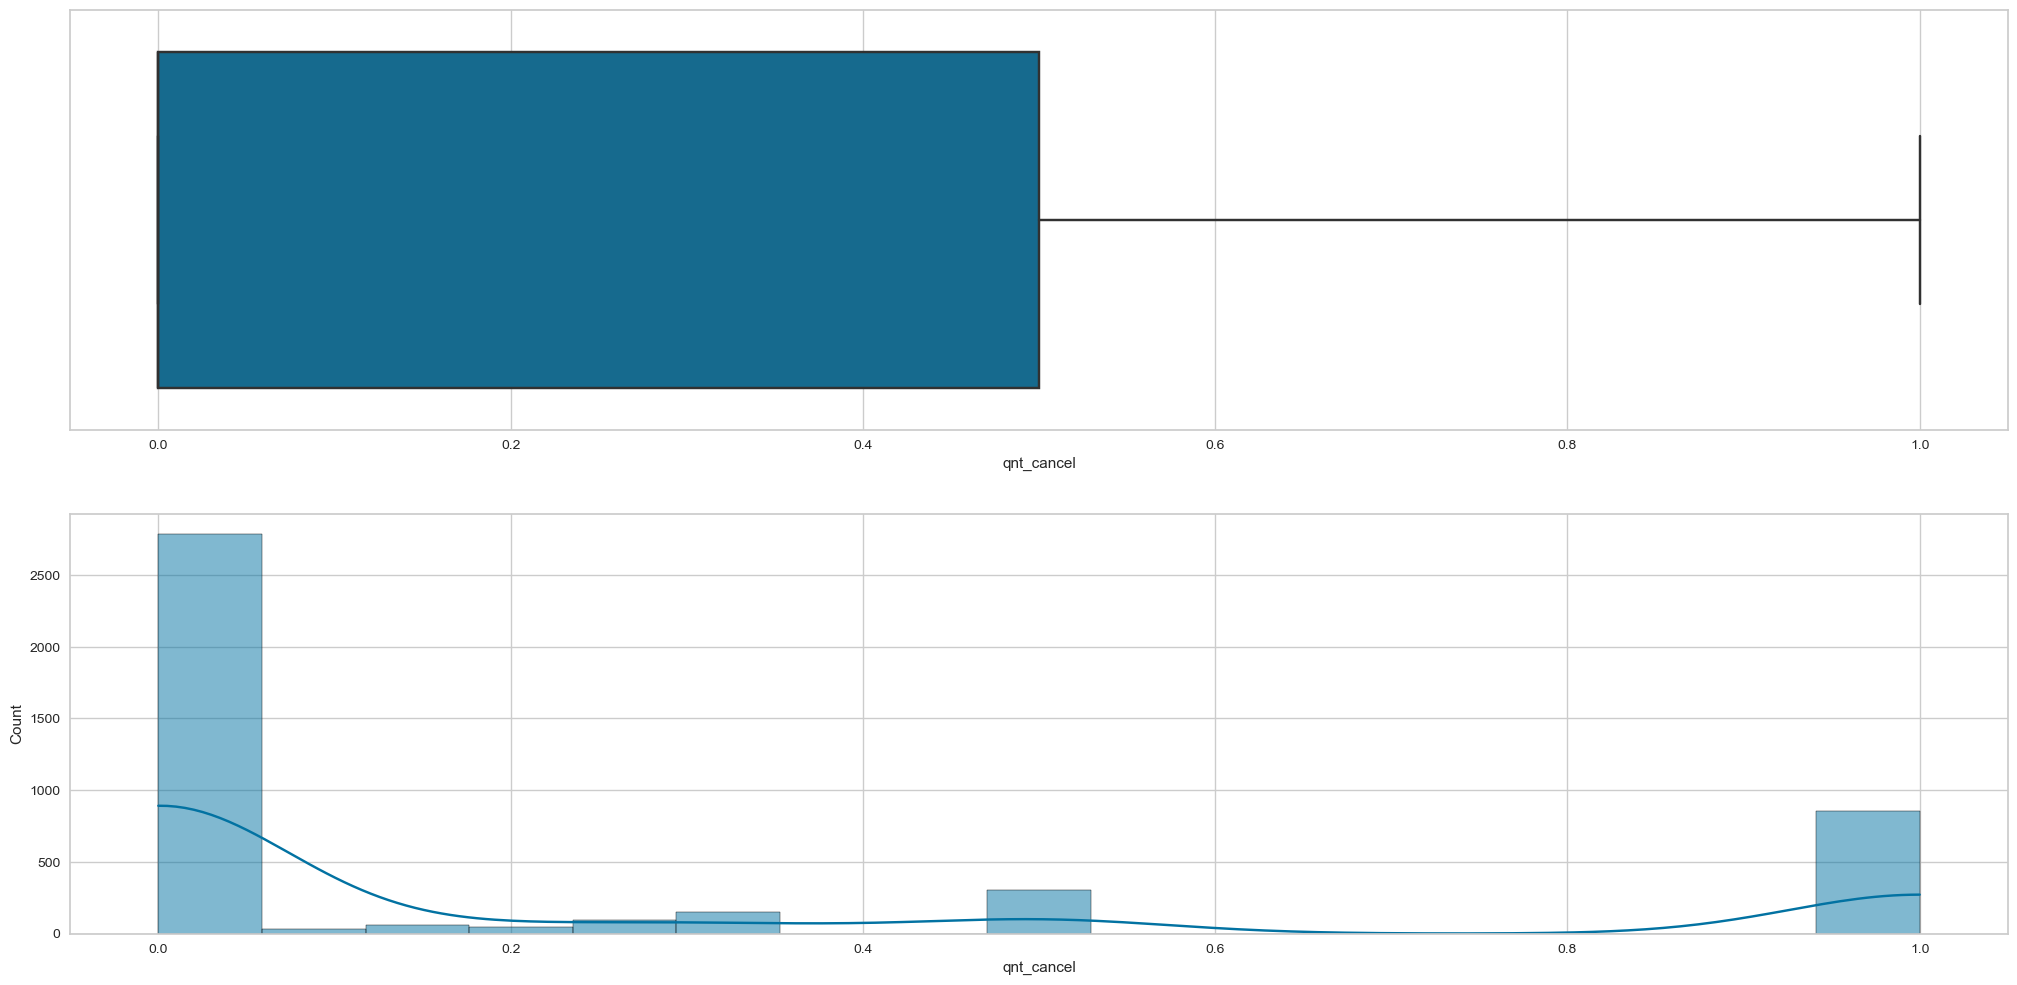

In [31]:
# Boxplot: para avaliar a distribuição e existencia de outliers
plt.subplot(2,1,1)
sns.boxplot(x=df_spaces['qnt_cancel'])

# Histplot: para verificar se há curvar normal/gaussiana
plt.subplot(2,1,2)
sns.histplot(df_spaces['qnt_cancel'], kde=True)

# ['total_valor', 'total_transacoes', 'ticket_medio',
#        'recencia_ultima_compra', 'recencia_media_3', 'rencencia_media_total',
#        'qnt_cancel']

In [32]:
# Scaler
rs = pp.RobustScaler()

df_spaces['total_valor'] = rs.fit_transform( df_spaces[['total_valor']])
df_spaces['total_transacoes'] = rs.fit_transform( df_spaces[['total_transacoes']])
df_spaces['ticket_medio'] = rs.fit_transform( df_spaces[['ticket_medio']])
df_spaces['recencia_ultima_compra'] = rs.fit_transform( df_spaces[['recencia_ultima_compra']])
df_spaces['recencia_media_3'] = rs.fit_transform( df_spaces[['recencia_media_3']])
df_spaces['rencencia_media_total'] = rs.fit_transform( df_spaces[['rencencia_media_total']])
df_spaces['qnt_cancel'] = rs.fit_transform( df_spaces[['qnt_cancel']])

In [33]:
X = df_spaces.copy()

## 4.3.1 PCA

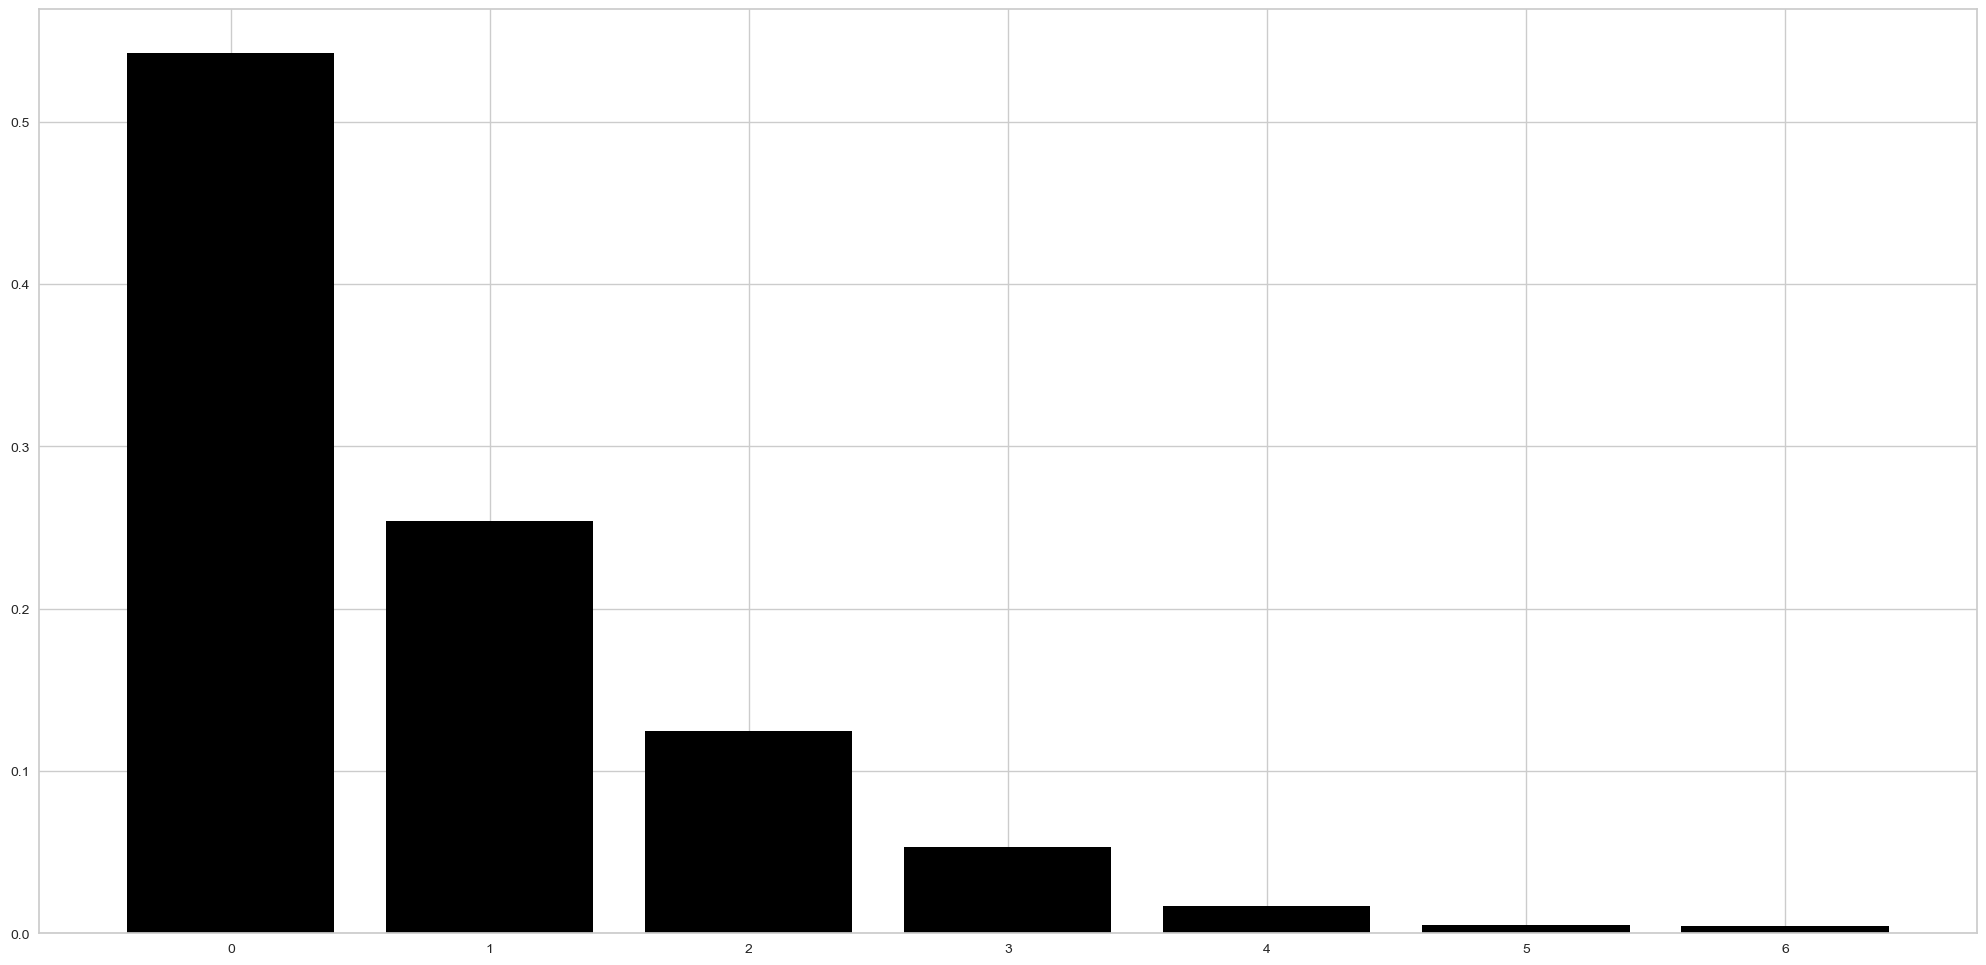

In [34]:
pca = dd.PCA( n_components=X.shape[1] )
principal_component = pca.fit_transform(X)
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')

# pca component
df_pca = pd.DataFrame(principal_component)

<Axes: xlabel='0', ylabel='1'>

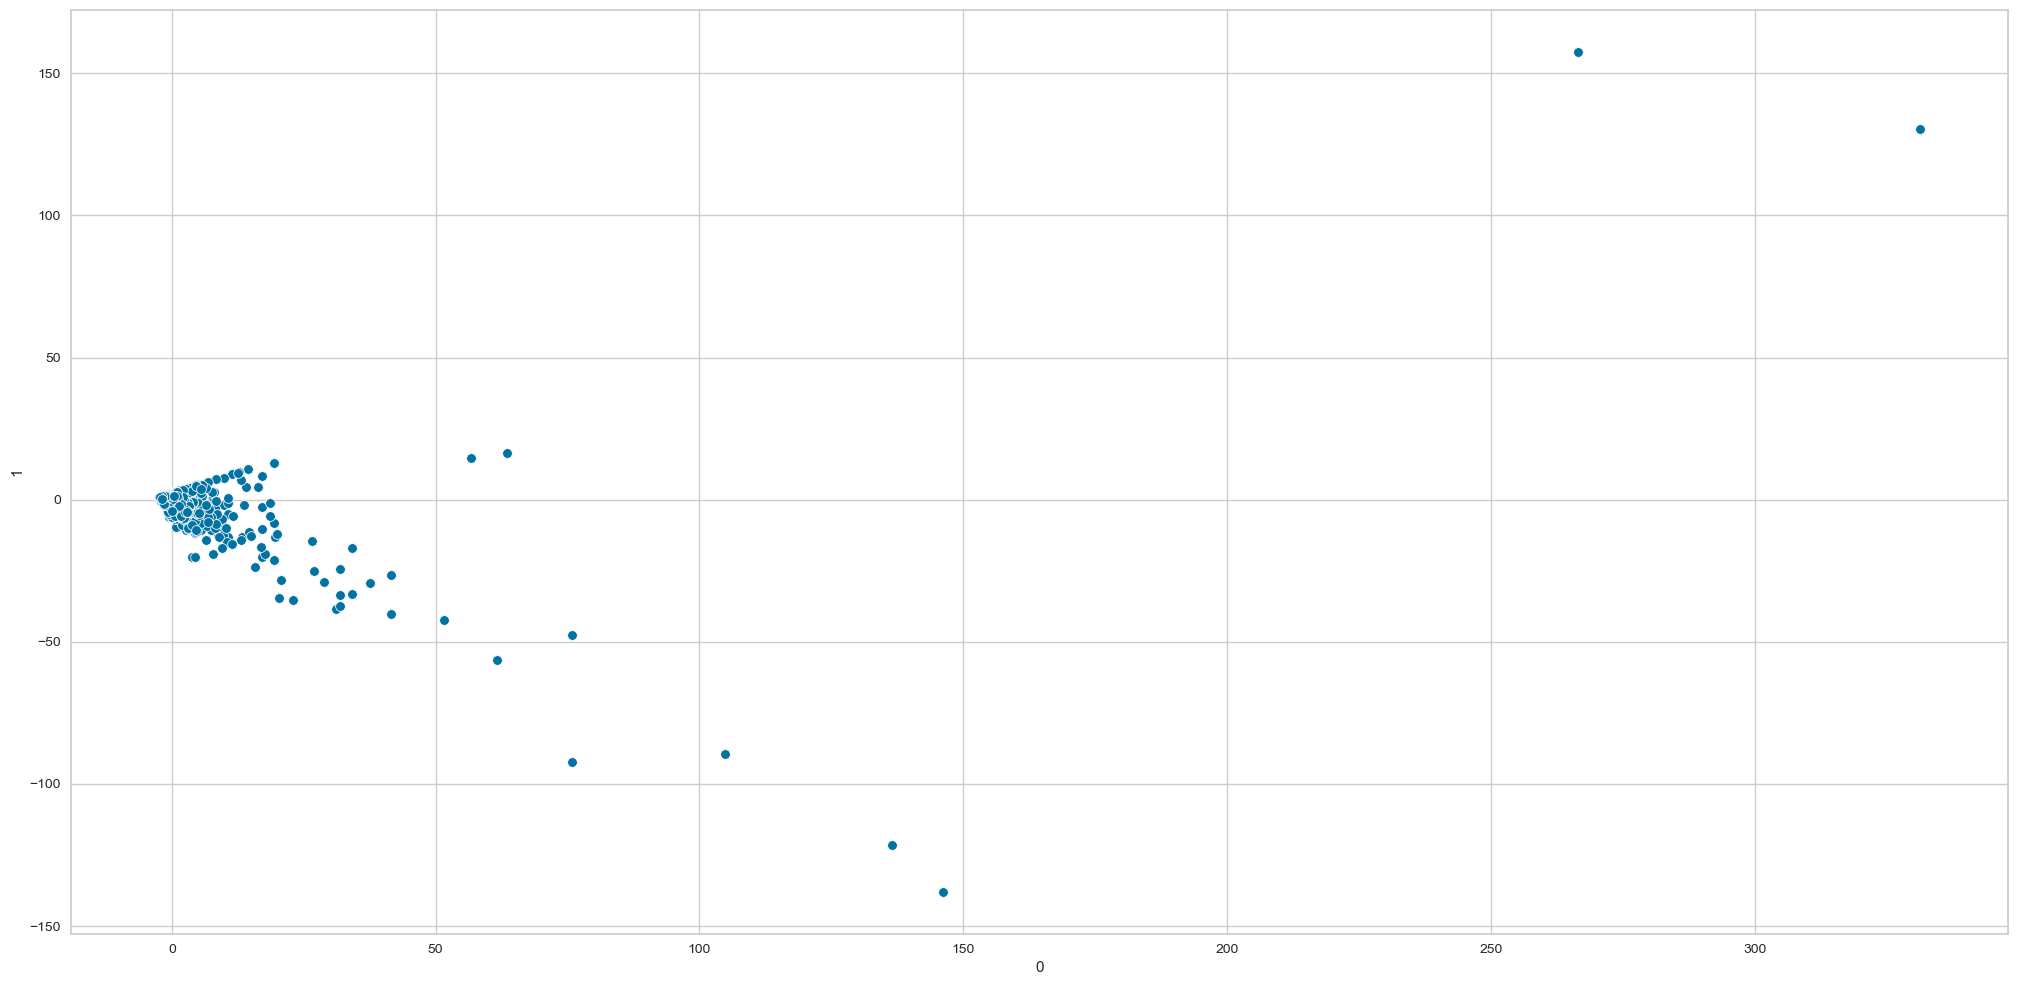

In [35]:
sns.scatterplot(x=0, y=1, data=df_pca)

## 4.3.2 UMAP

<Axes: xlabel='embedding_x', ylabel='embedding_y'>

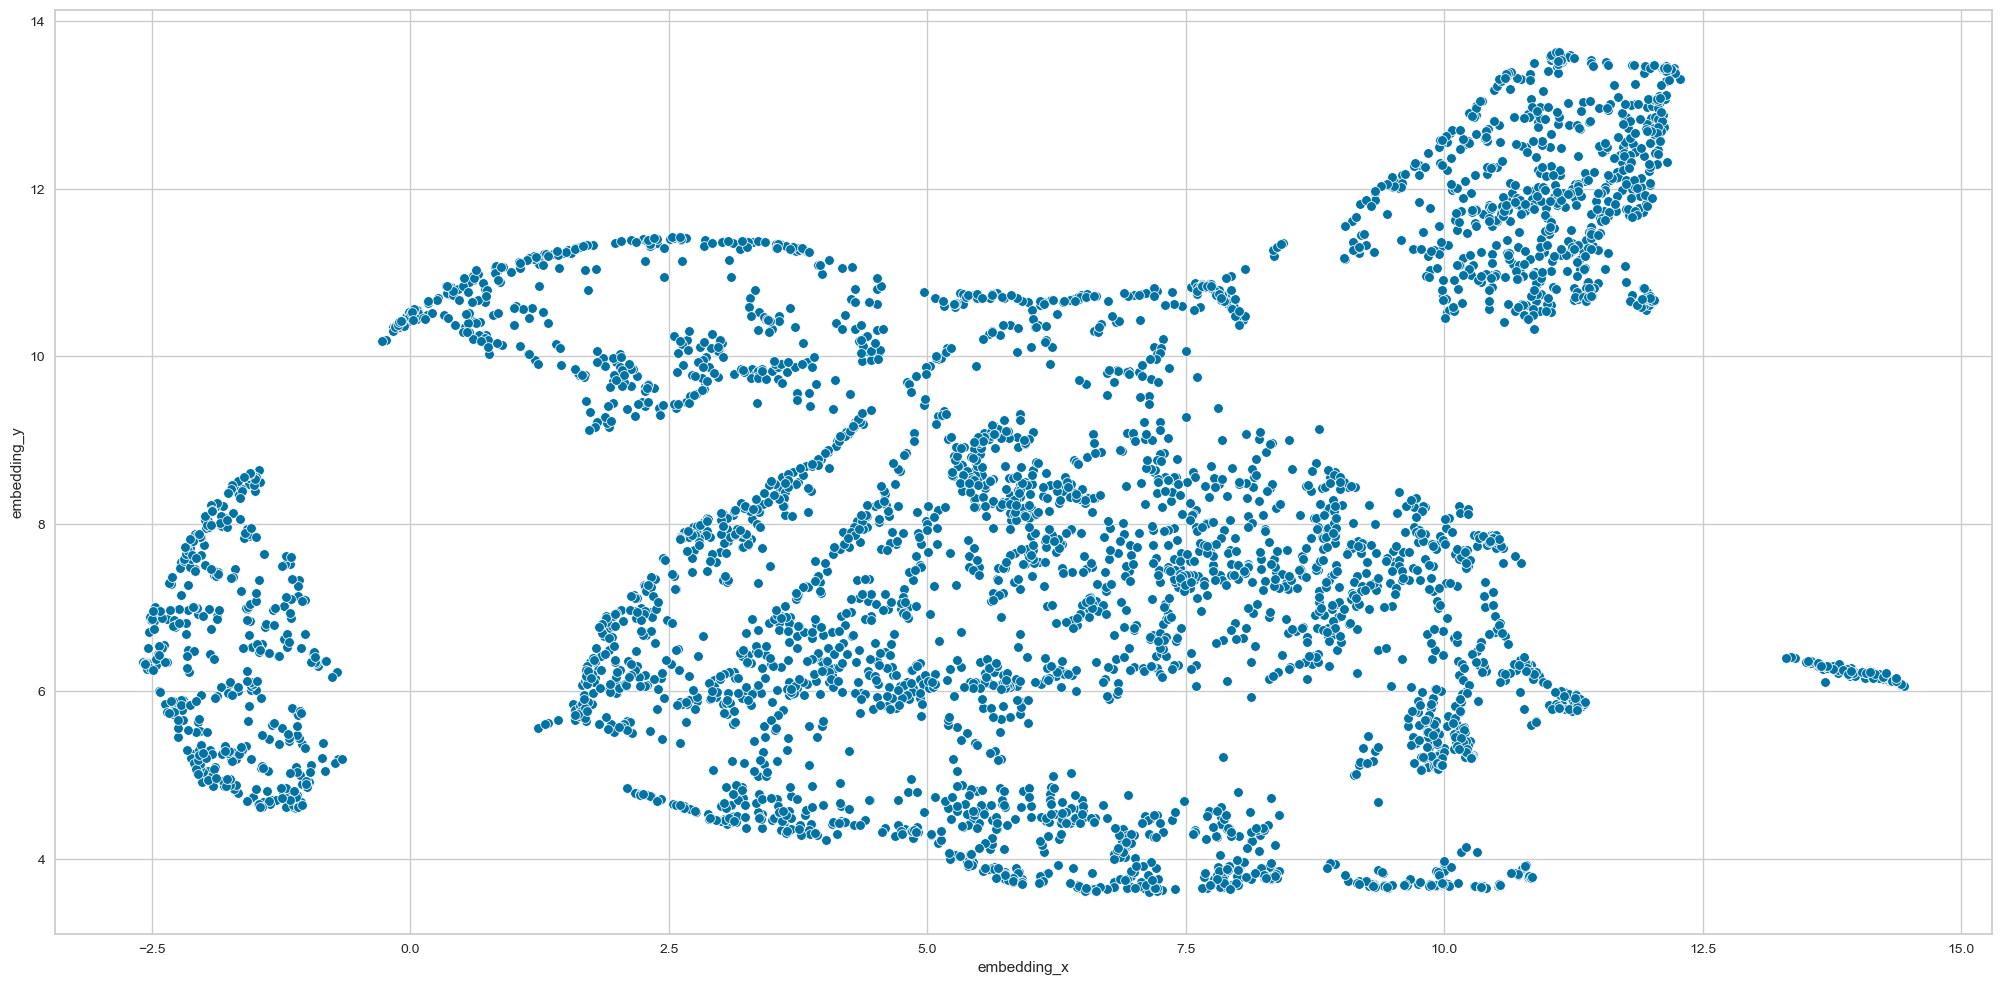

In [36]:
reducer = umap.UMAP( n_neighbors=80, random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_umap = pd.DataFrame()
df_umap['embedding_x'] = embedding[:, 0]
df_umap['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot(x='embedding_x', 
                y='embedding_y',
                data=df_umap)

### 4.3.3 t-SNE

<Axes: xlabel='embedding_x', ylabel='embedding_y'>

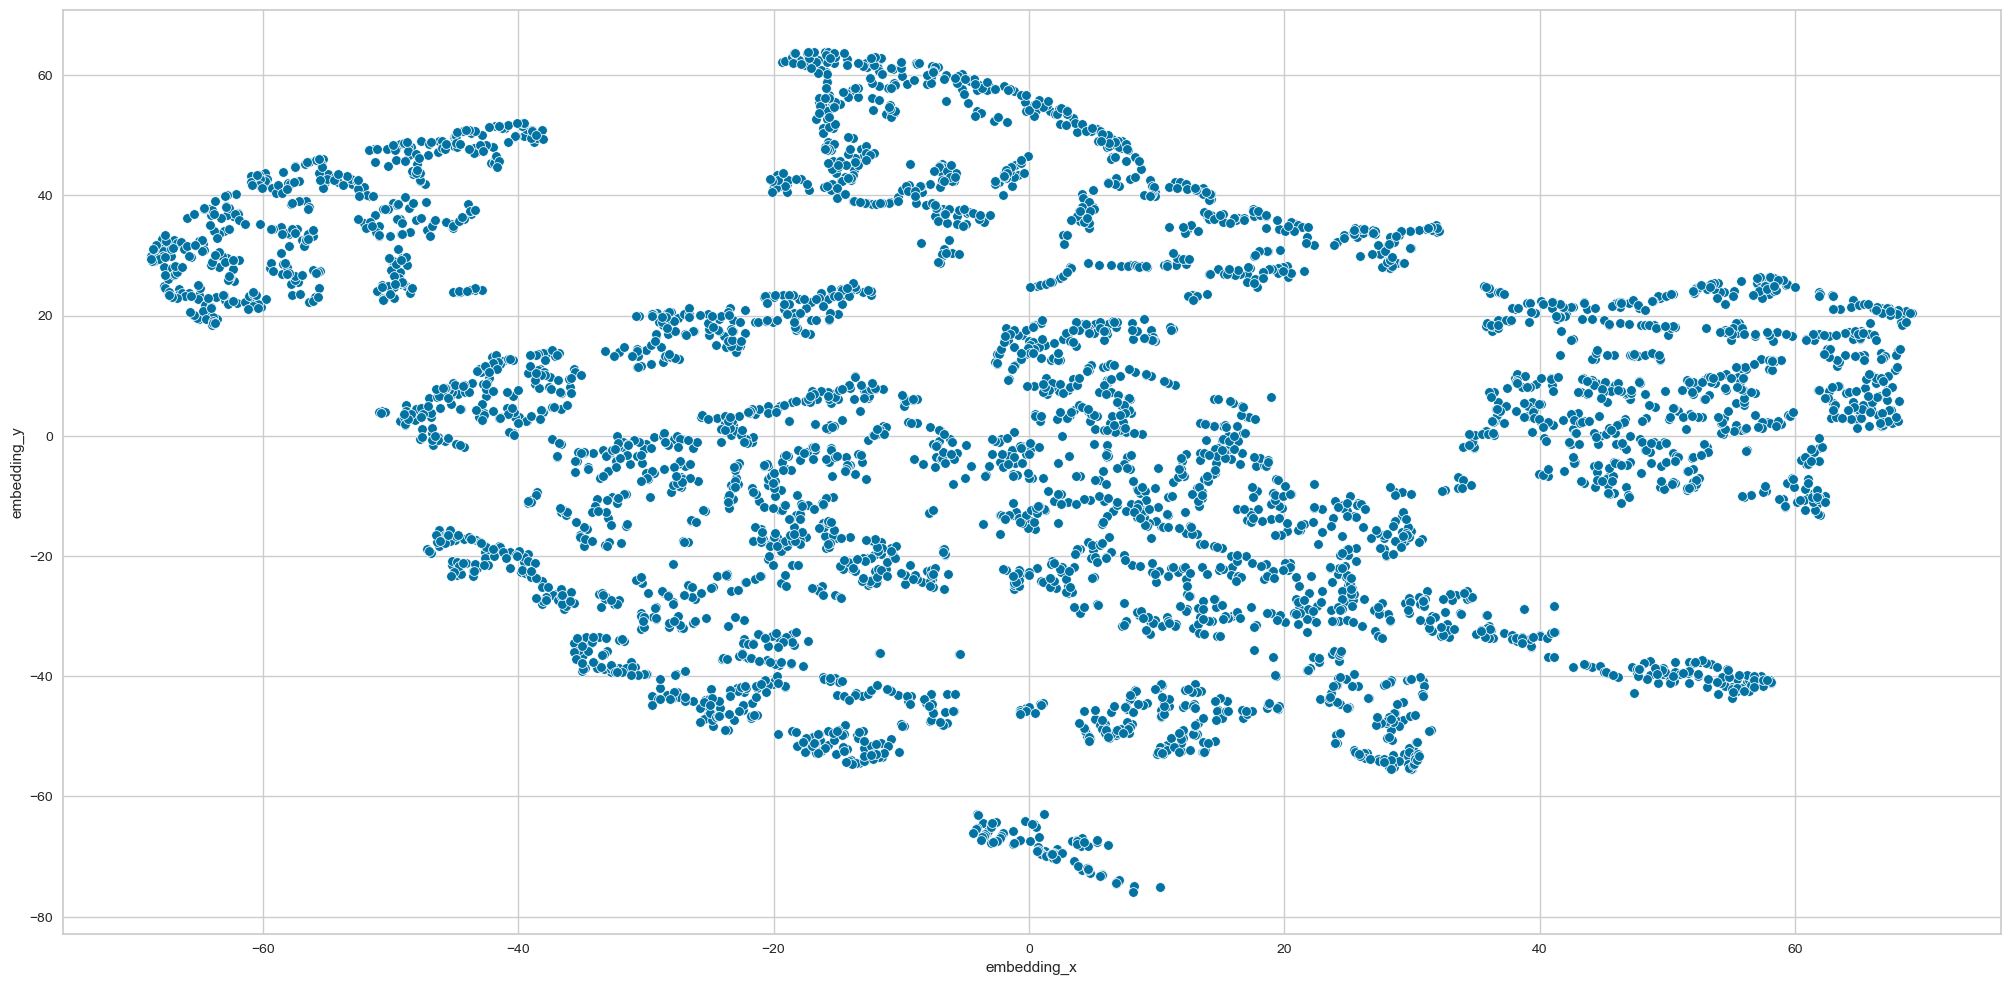

In [37]:
from sklearn import manifold as mn

reducer = mn.TSNE( n_components=2, random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_umap = pd.DataFrame()
df_umap['embedding_x'] = embedding[:, 0]
df_umap['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot(x='embedding_x', 
                y='embedding_y',
                data=df_umap)

### 4.3.4 Tree-based Embedding

In [38]:
from sklearn import ensemble as en

In [39]:
X = df_spaces.drop(columns=['total_valor'], axis=1).copy()
y = df_spaces['total_valor'].copy()

# model definiton
forest = en.RandomForestRegressor( n_estimators=100, 
                                  random_state=42,
                                   criterion='friedman_mse' )

# model training
forest.fit( X, y )

# predict
df_leaf = pd.DataFrame(forest.apply( X ))

<Axes: xlabel='embedding_x', ylabel='embedding_y'>

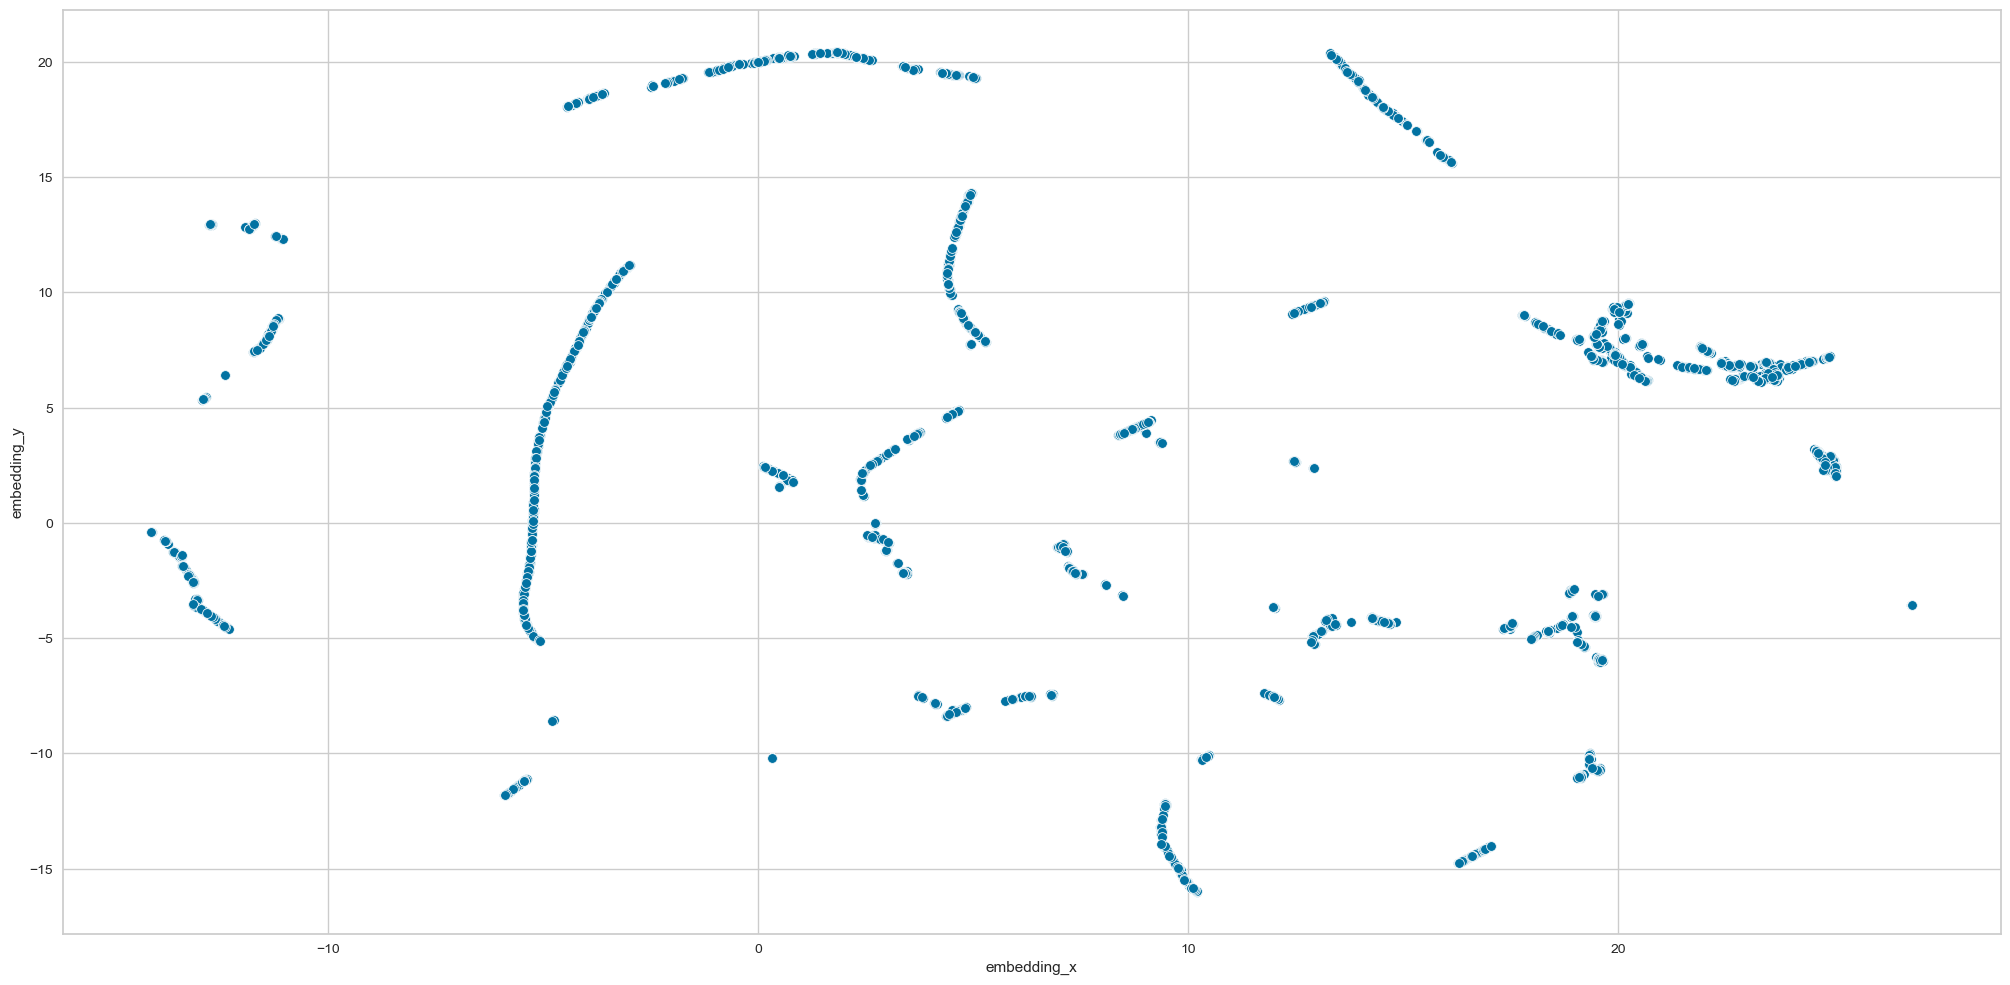

In [40]:
reducer = umap.UMAP( n_neighbors=80, random_state=42 )
embedding = reducer.fit_transform( df_leaf )

# embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot(x='embedding_x', 
                y='embedding_y',
                data=df_tree)

# **5.0 Data Preparation**

# 6.0 Feature Selection

# **7.0 Hyperparameter Fine-Tuning**

Em problemas de clusterização, o número de clusters precisa ser fornecido ao algoritmo previamente. Por isso primeiro fazemos o fine-tunning para encontrar o número ideal de clusters (k).

In [41]:
X = df_tree.copy()

In [42]:
X

,embedding_x,embedding_y
0,24.26,6.92
1,20.05,6.93
2,3.36,19.82
3,18.69,-4.42
4,-11.08,12.33
...,...,...
4328,-5.08,-5.11
4329,-3.89,8.94
4330,4.73,13.33
4331,22.63,6.20


In [43]:
df_tree.isna().sum()

embedding_x    0
embedding_y    0
dtype: int64

In [56]:
clusters = np.arange(2, 200, 1)

## 7.1 K-Means

In [45]:
X.isna().sum()

embedding_x    0
embedding_y    0
dtype: int64

In [57]:
kmeans_list = []
for k in clusters:
    # model definition
    kmeans_model = c.KMeans( n_clusters=k , n_init=10)

    # model training
    kmeans_model.fit( X )

    # model predict
    labels = kmeans_model.predict( X )

    # model performance
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    kmeans_list.append( sil )

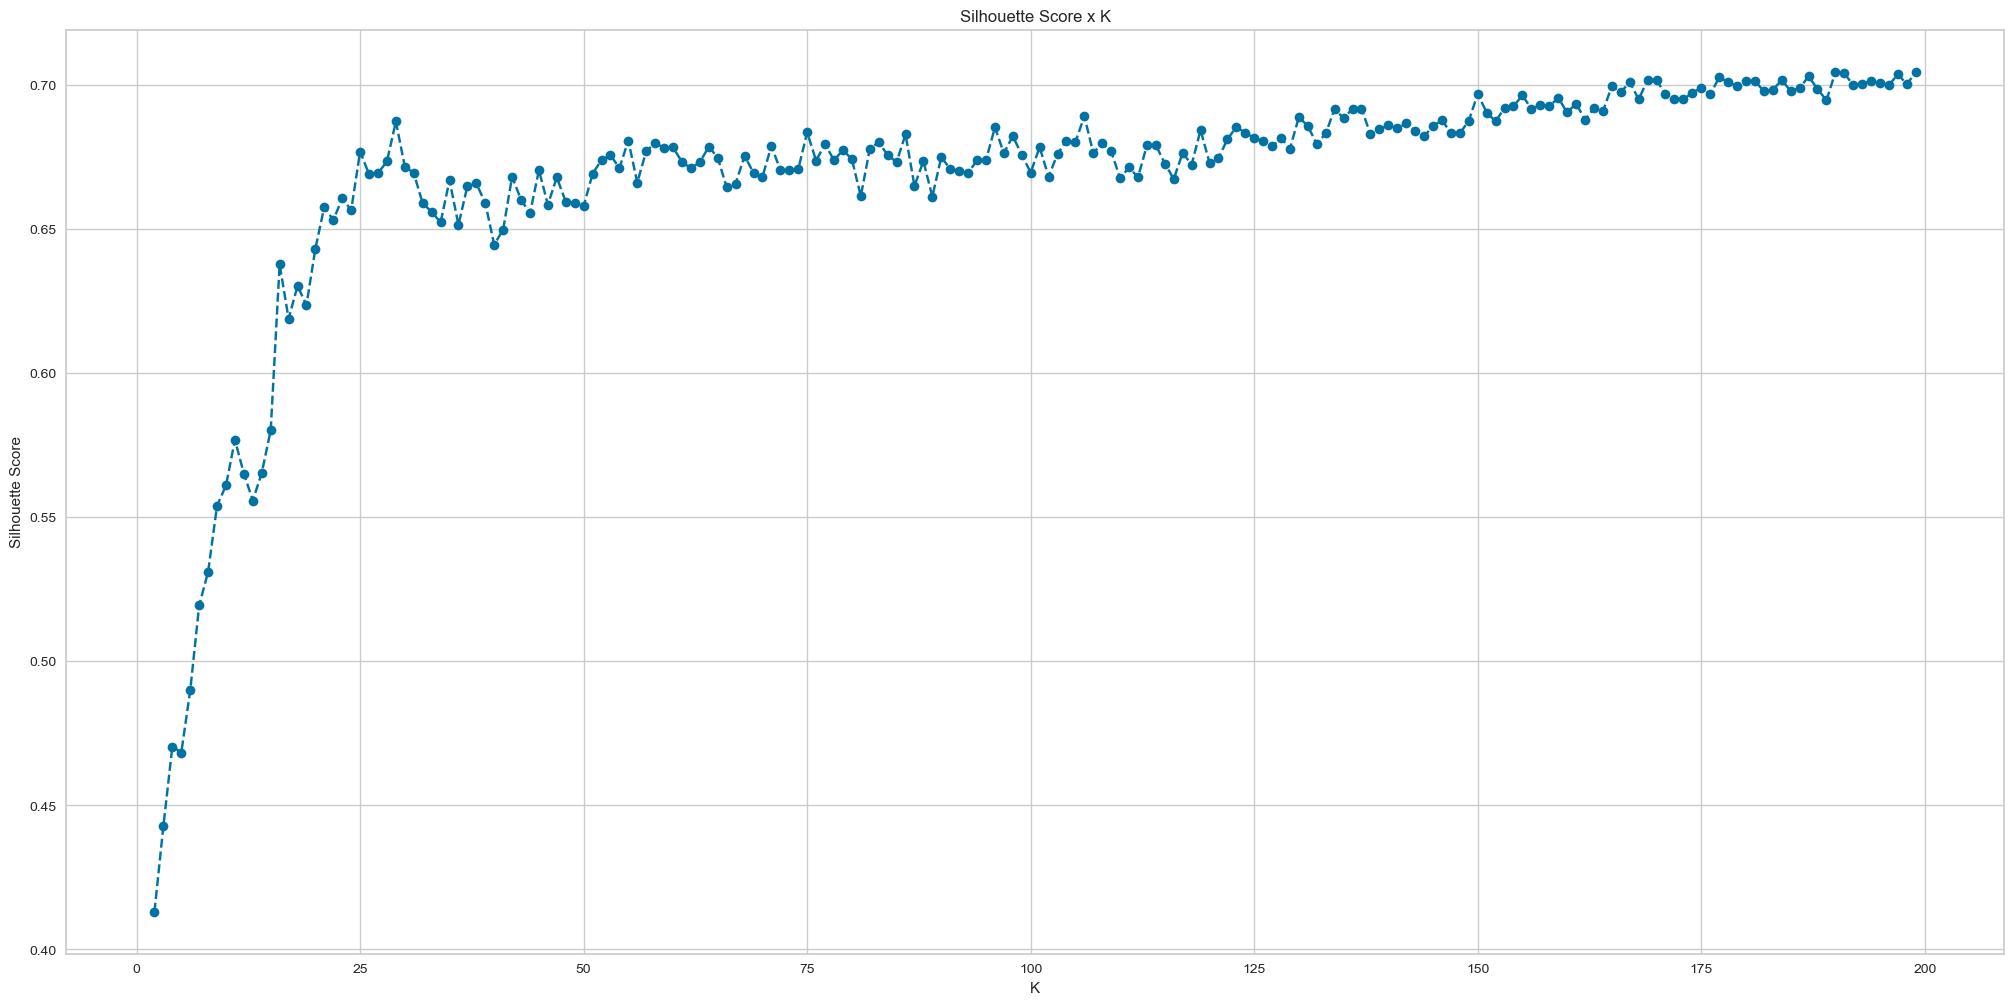

In [58]:
plt.plot( clusters, kmeans_list, linestyle='--', marker='o', color='b' )
plt.xlabel( 'K' );
plt.ylabel( 'Silhouette Score' );
plt.title( 'Silhouette Score x K' );

## 7.2 GMM

In [61]:
from sklearn.mixture import GaussianMixture

In [62]:
gmm_list = []
for k in clusters:
    # model definition
    gmm_model = GaussianMixture( n_components=k )

    # model training
    gmm_model.fit( X )

    # model predict
    labels = gmm_model.predict( X )

    # model performance
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    gmm_list.append( sil )

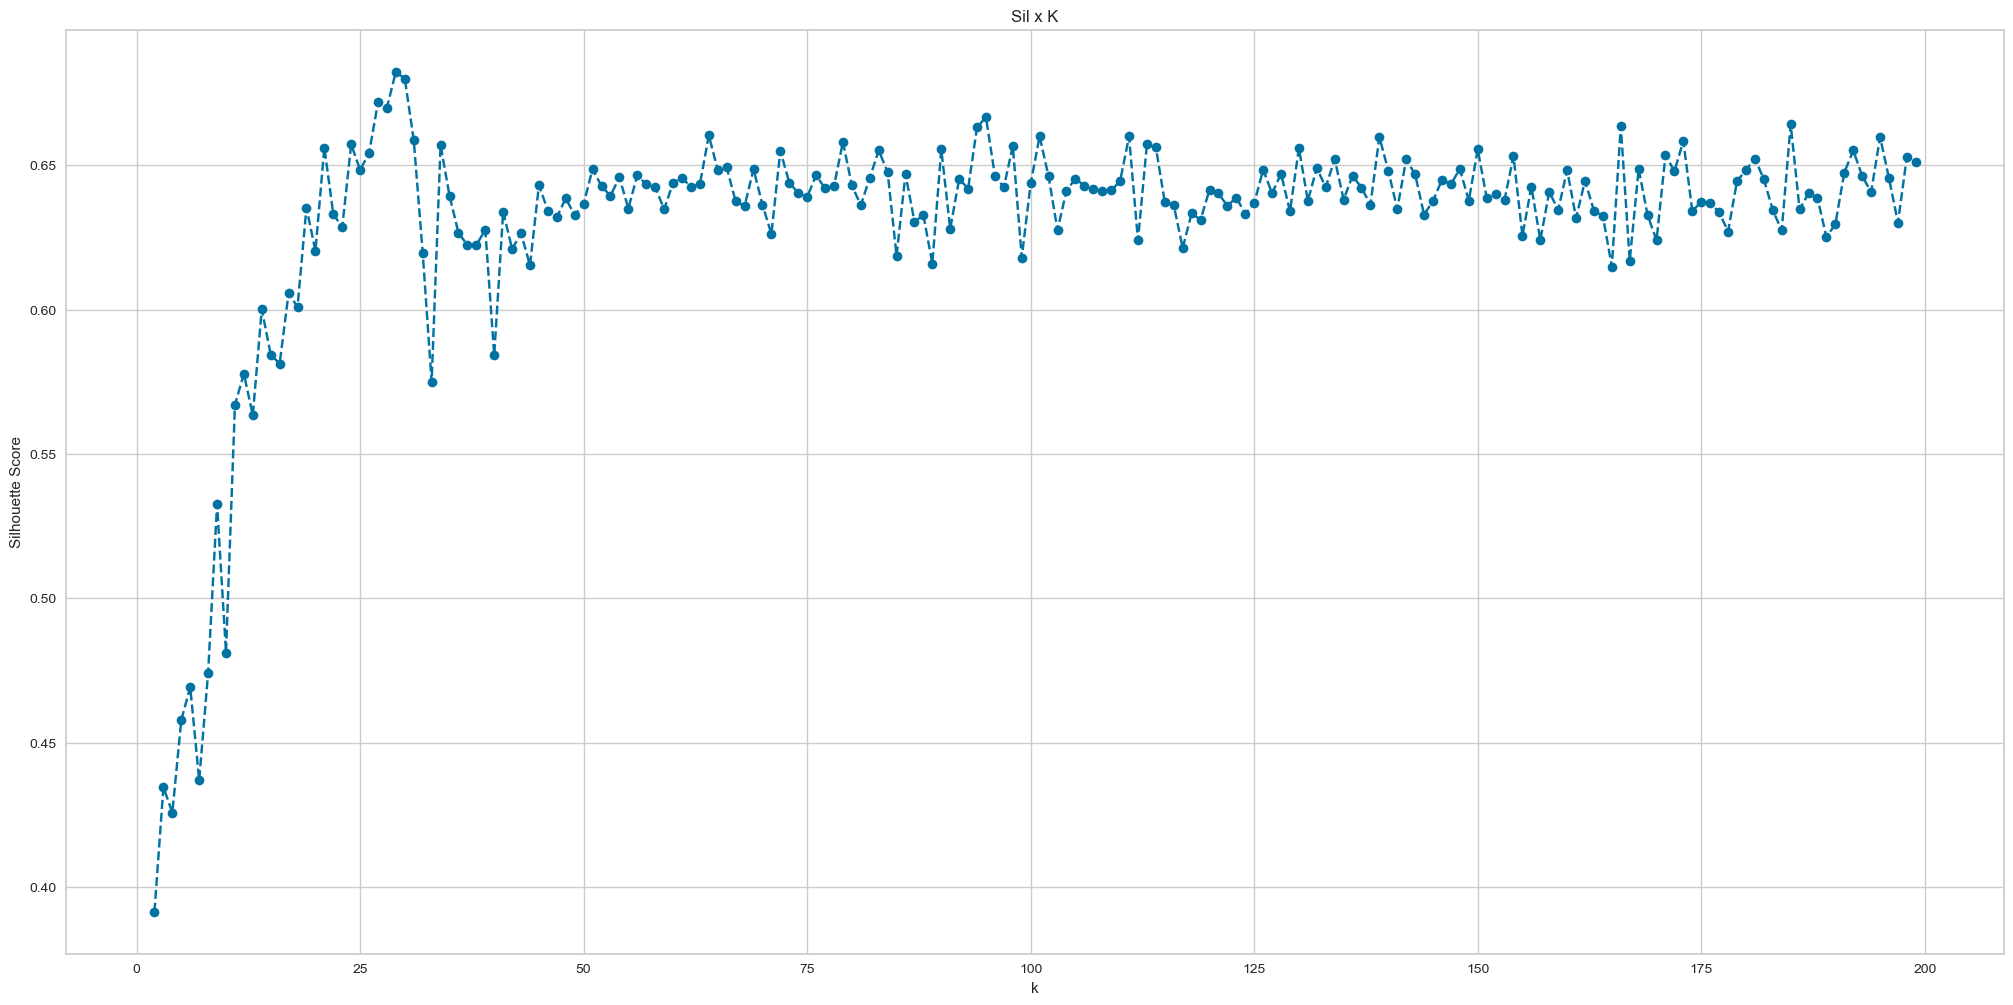

In [64]:
plt.plot( clusters, gmm_list, linestyle='--', marker='o', color='b' )
plt.xlabel( 'k');
plt.ylabel( 'Silhouette Score');
plt.title( 'Sil x K');

## 7.3 Hierarchical Clustering

In [63]:
from scipy.cluster import hierarchy as hc

In [65]:
# model definition and training
hc_model = hc.linkage( X, 'ward' )

In [67]:
hc_list = []
for k in clusters:
    # model definition & training
    hc_model = hc.linkage( X, 'ward' )

    # model predict
    labels = hc.fcluster( hc_model, k, criterion='maxclust' )

    # metrics
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    hc_list.append( sil )

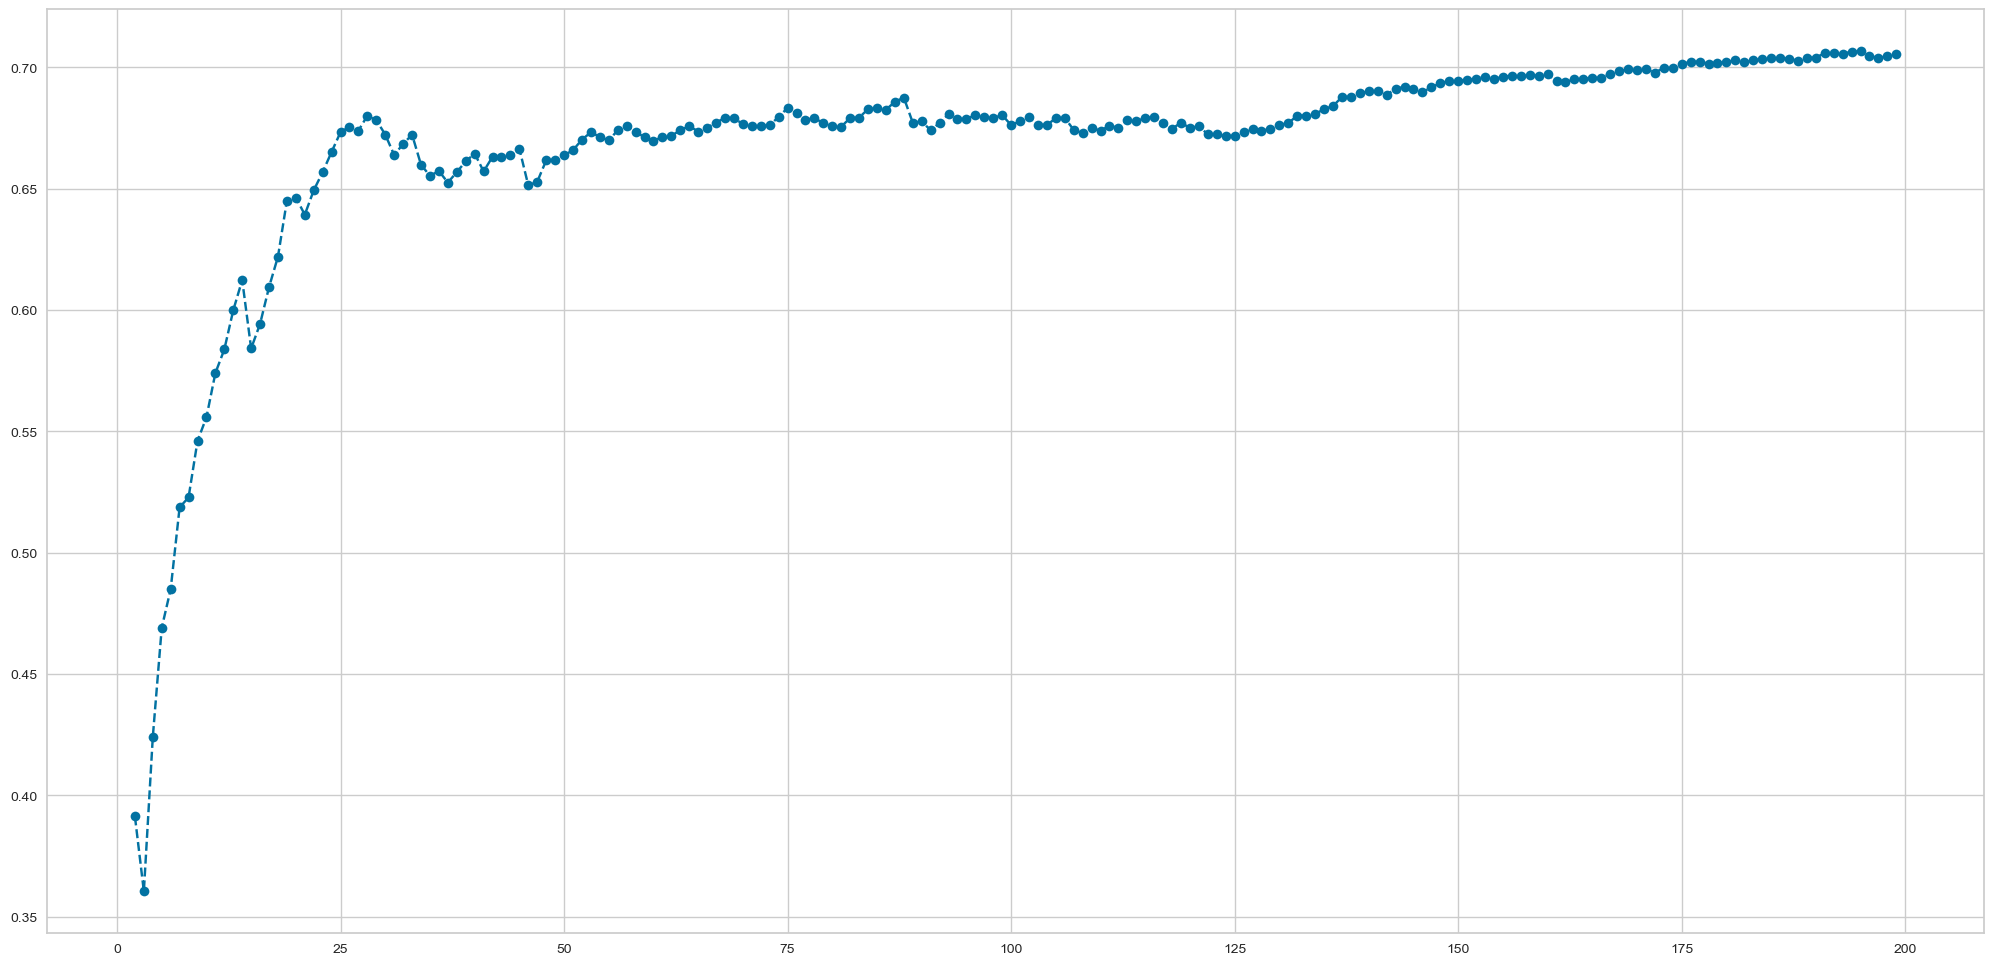

In [68]:
plt.plot( clusters,  hc_list, linestyle='--', marker='o', color='b' )

## 7.4 DBSCAN

In [69]:
from sklearn.neighbors import NearestNeighbors

In [70]:
eps=2.0
min_samples=20 

# model definition
dbscan_model = c.DBSCAN( eps=eps, min_samples=min_samples )

# mode training & predict 
labels = dbscan_model.fit_predict( X )

sil = m.silhouette_score( X, labels, metric='euclidean' )
print( 'Silhouette Score: {}'.format( sil ) )
print( 'Number of Clusters: {}'.format( len( np.unique( labels ) ) ) )
print( np.unique( labels ) )

Silhouette Score: 0.613761305809021
Number of Clusters: 24
[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]


## 7.5 Results

In [71]:
df_results = pd.DataFrame( 
    {'KMeans': kmeans_list, 
     'GMM': gmm_list,
     'HC': hc_list}
     #'DBSCAN': dbscan_list}
).T

df_results.columns = clusters

In [72]:
df_results.style.highlight_max( color='lightgreen', axis=1 )

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
KMeans,0.413093,0.442888,0.470432,0.468308,0.489941,0.519458,0.531083,0.554062,0.561068,0.576909,0.565157,0.555846,0.565408,0.580251,0.637796,0.618952,0.630331,0.623668,0.643307,0.657883,0.653113,0.660783,0.656631,0.676971,0.669111,0.669523,0.673528,0.687430,0.671741,0.669521,0.658998,0.656100,0.652365,0.667008,0.651546,0.665019,0.665893,0.659111,0.644637,0.649921,0.668264,0.660246,0.655526,0.670516,0.658555,0.668022,0.659547,0.658975,0.657989,0.669264,0.674076,0.675719,0.671275,0.680800,0.666174,0.677150,0.679878,0.678323,0.678417,0.673392,0.671196,0.673324,0.678646,0.674842,0.664530,0.665844,0.675508,0.669575,0.668228,0.678899,0.670620,0.670423,0.670792,0.683657,0.673841,0.679635,0.673932,0.677520,0.674324,0.661491,0.677859,0.680230,0.675790,0.673320,0.682938,0.665045,0.673662,0.661328,0.675084,0.670861,0.670324,0.669460,0.674019,0.674013,0.685376,0.676411,0.682324,0.675910,0.669691,0.678507,0.668240,0.676126,0.680721,0.680178,0.689292,0.676503,0.679853,0.677125,0.667628,0.671507,0.667998,0.679118,0.679239,0.672831,0.667478,0.676534,0.672433,0.684426,0.673098,0.674741,0.681196,0.685557,0.683418,0.681784,0.680640,0.678847,0.681662,0.677996,0.689005,0.685770,0.679600,0.683299,0.691773,0.688505,0.691869,0.691917,0.682961,0.684821,0.686050,0.685042,0.686807,0.684240,0.682270,0.685808,0.687861,0.683458,0.683305,0.687695,0.696974,0.690534,0.687474,0.692149,0.692773,0.696441,0.691831,0.693087,0.692655,0.695644,0.690545,0.693615,0.688074,0.691960,0.690937,0.699714,0.697507,0.701227,0.695076,0.701897,0.701655,0.697034,0.695149,0.695178,0.697273,0.699197,0.696795,0.702703,0.701176,0.699611,0.701485,0.701476,0.697933,0.698368,0.701787,0.698010,0.698977,0.703082,0.698703,0.694752,0.704487,0.704086,0.700078,0.700404,0.701578,0.700847,0.700130,0.703774,0.700307,0.704693
GMM,0.391468,0.434571,0.425827,0.457848,0.469305,0.436999,0.474193,0.532619,0.481249,0.567055,0.577751,0.563434,0.600120,0.584453,0.581271,0.605700,0.600920,0.635330,0.620305,0.656156,0.633135,0.628522,0.657261,0.648394,0.654163,0.671768,0.669974,0.682403,0.679937,0.658612,0.619741,0.574956,0.656982,0.639450,0.626585,0.622388,0.622354,0.627670,0.584295,0.633972,0.621004,0.626381,0.615403,0.643101,0.634323,0.632011,0.638528,0.632720,0.636532,0.648775,0.642751,0.639412,0.645868,0.635028,0.646508,0.643424,0.642560,0.634688,0.643916,0.645683,0.642509,0.643373,0.660319,0.648448,0.649241,0.637510,0.635814,0.648683,0.636324,0.626189,0.655016,0.644004,0.640378,0.638999,0.646565,0.641974,0.642786,0.658066,0.643004,0.636171,0.645600,0.655165,0.647615,0.618655,0.647001,0.630441,0.632716,0.615972,0.655520,0.628016,0.645262,0.641956,0.663154,0.666640,0.646328,0.642396,0.656732,0.618050,0.643691,0.660049,0.646114,0.627567,0.641158,0.645345,0.642948,0.641676,0.641050,0.641264,0.644508,0.659974,0.623975,0.657232,0.656206,0.637219,0.636254,0.621365,0.633327,0.631155,0.641521,0.640236,0.635953,0.638783,0.633228,0.636850,0.648432,0.640277,0.647071,0.634025,0.655973,0.637696,0.649076,0.642372,0.652173,0.638130,0.646379,0.642226,0.636340,0.659828,0.648126,0.634777,0.652103,0.646816,0.632895,0.637679,0.644942,0.643436,0.648778,0.637696,0.655540,0.638742,0.639882,0.638057,0.653165,0.625561,0.642639,0.624108,0.640800,0.634509,0.648363,0.631762,0.644633,0.634250,0.632367,0.614937,0.663565,0.616943,0.648722,0.632720,0.624034

## 7.1 Within-Cluster Sum of Square (WSS)

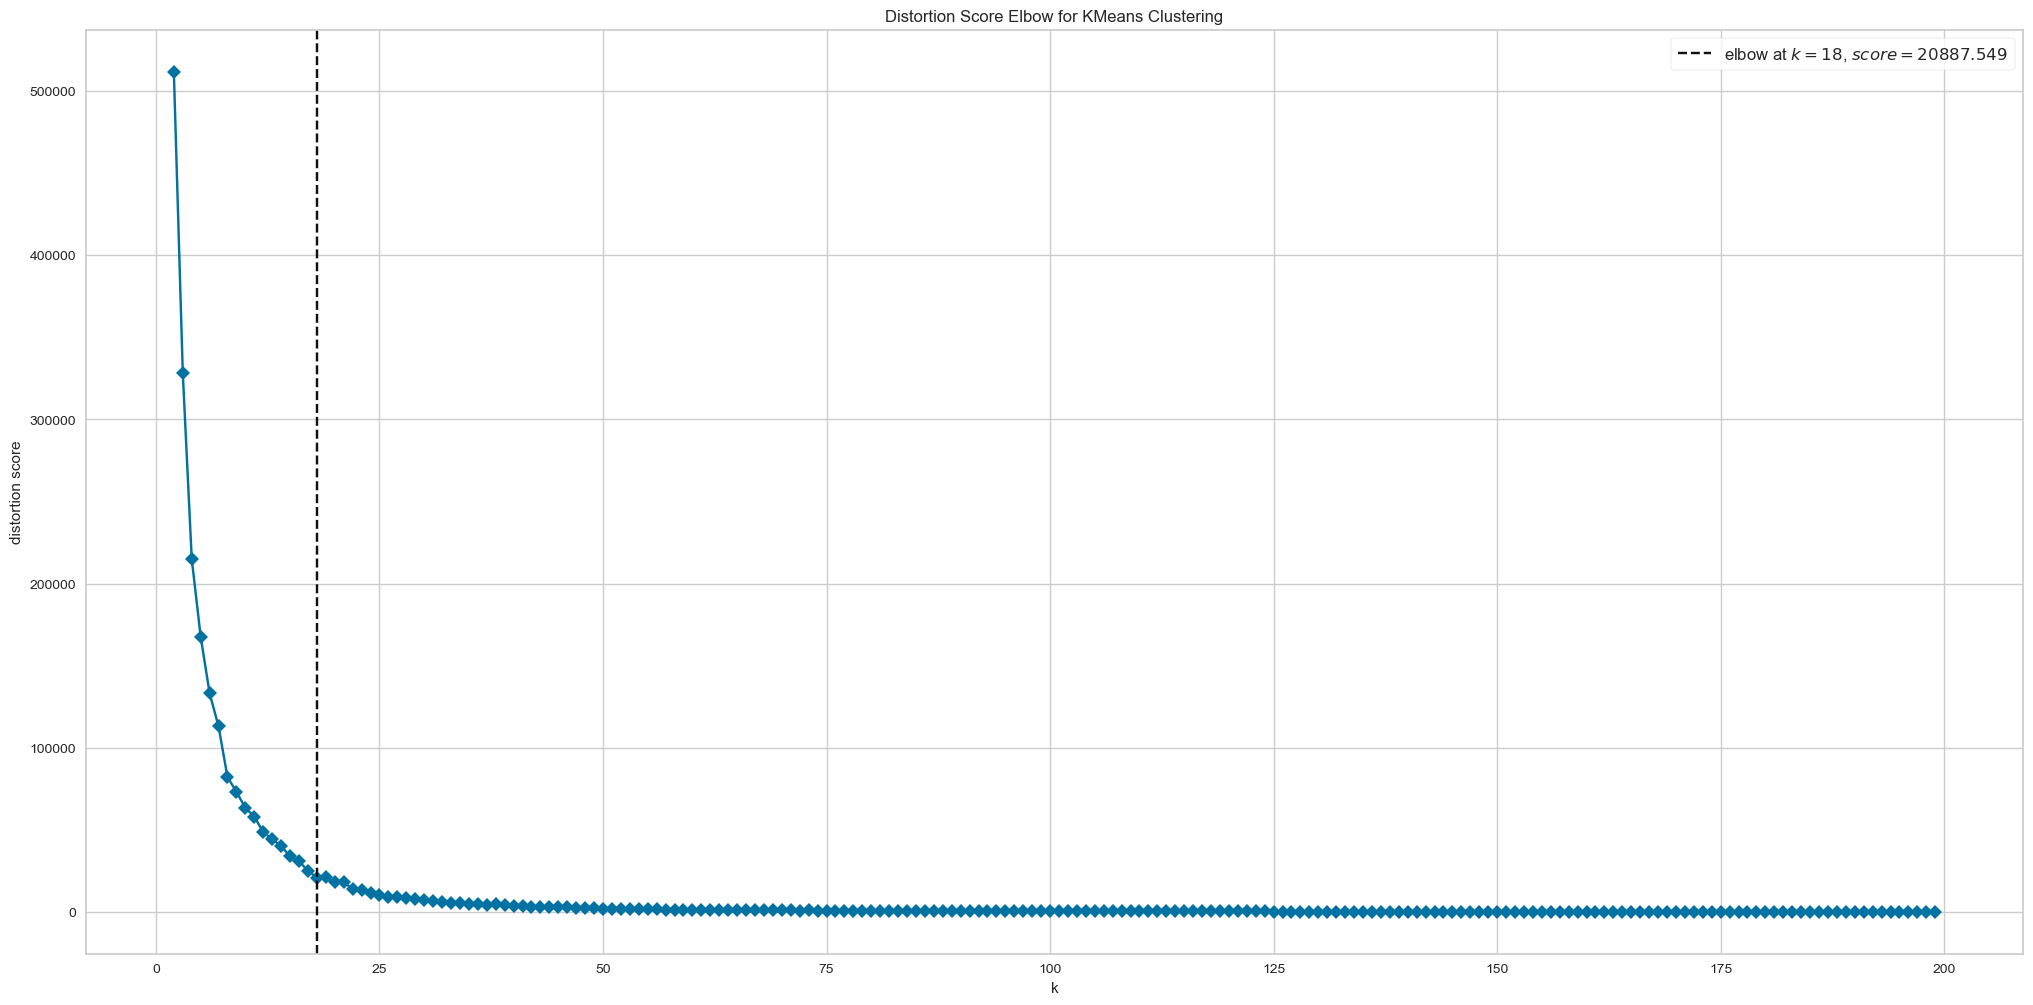

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [73]:
kmeans = KElbowVisualizer( c.KMeans(), k=clusters, n_init=20, timings=False)
kmeans.fit(X)
kmeans.show()

## 7.2 Silhouette Score

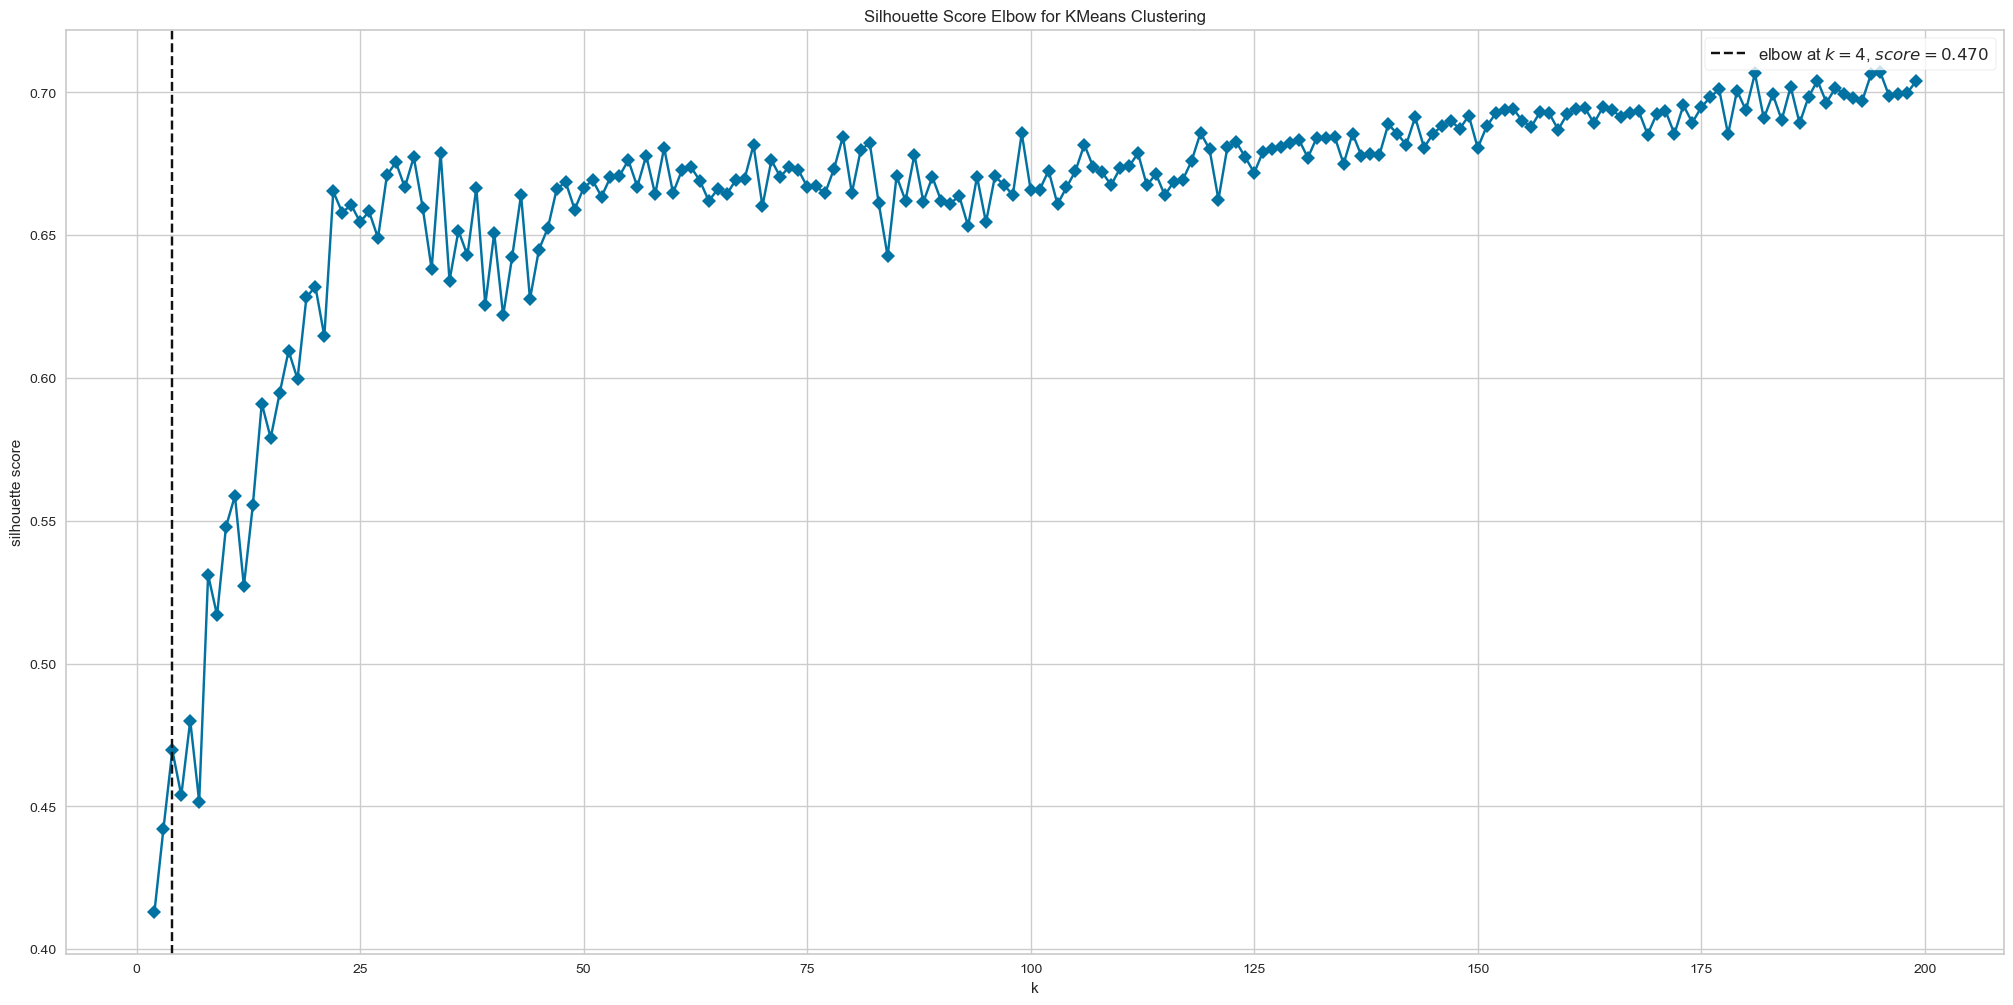

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [74]:
kmeans = KElbowVisualizer( c.KMeans(), k=clusters, metric='silhouette', timings=False, n_init=10 )
kmeans.fit( X )
kmeans.show()

## 7.3 Silhouette Analysis

### 7.3.2 Silhouette True

IndexError: index 4 is out of bounds for axis 0 with size 4

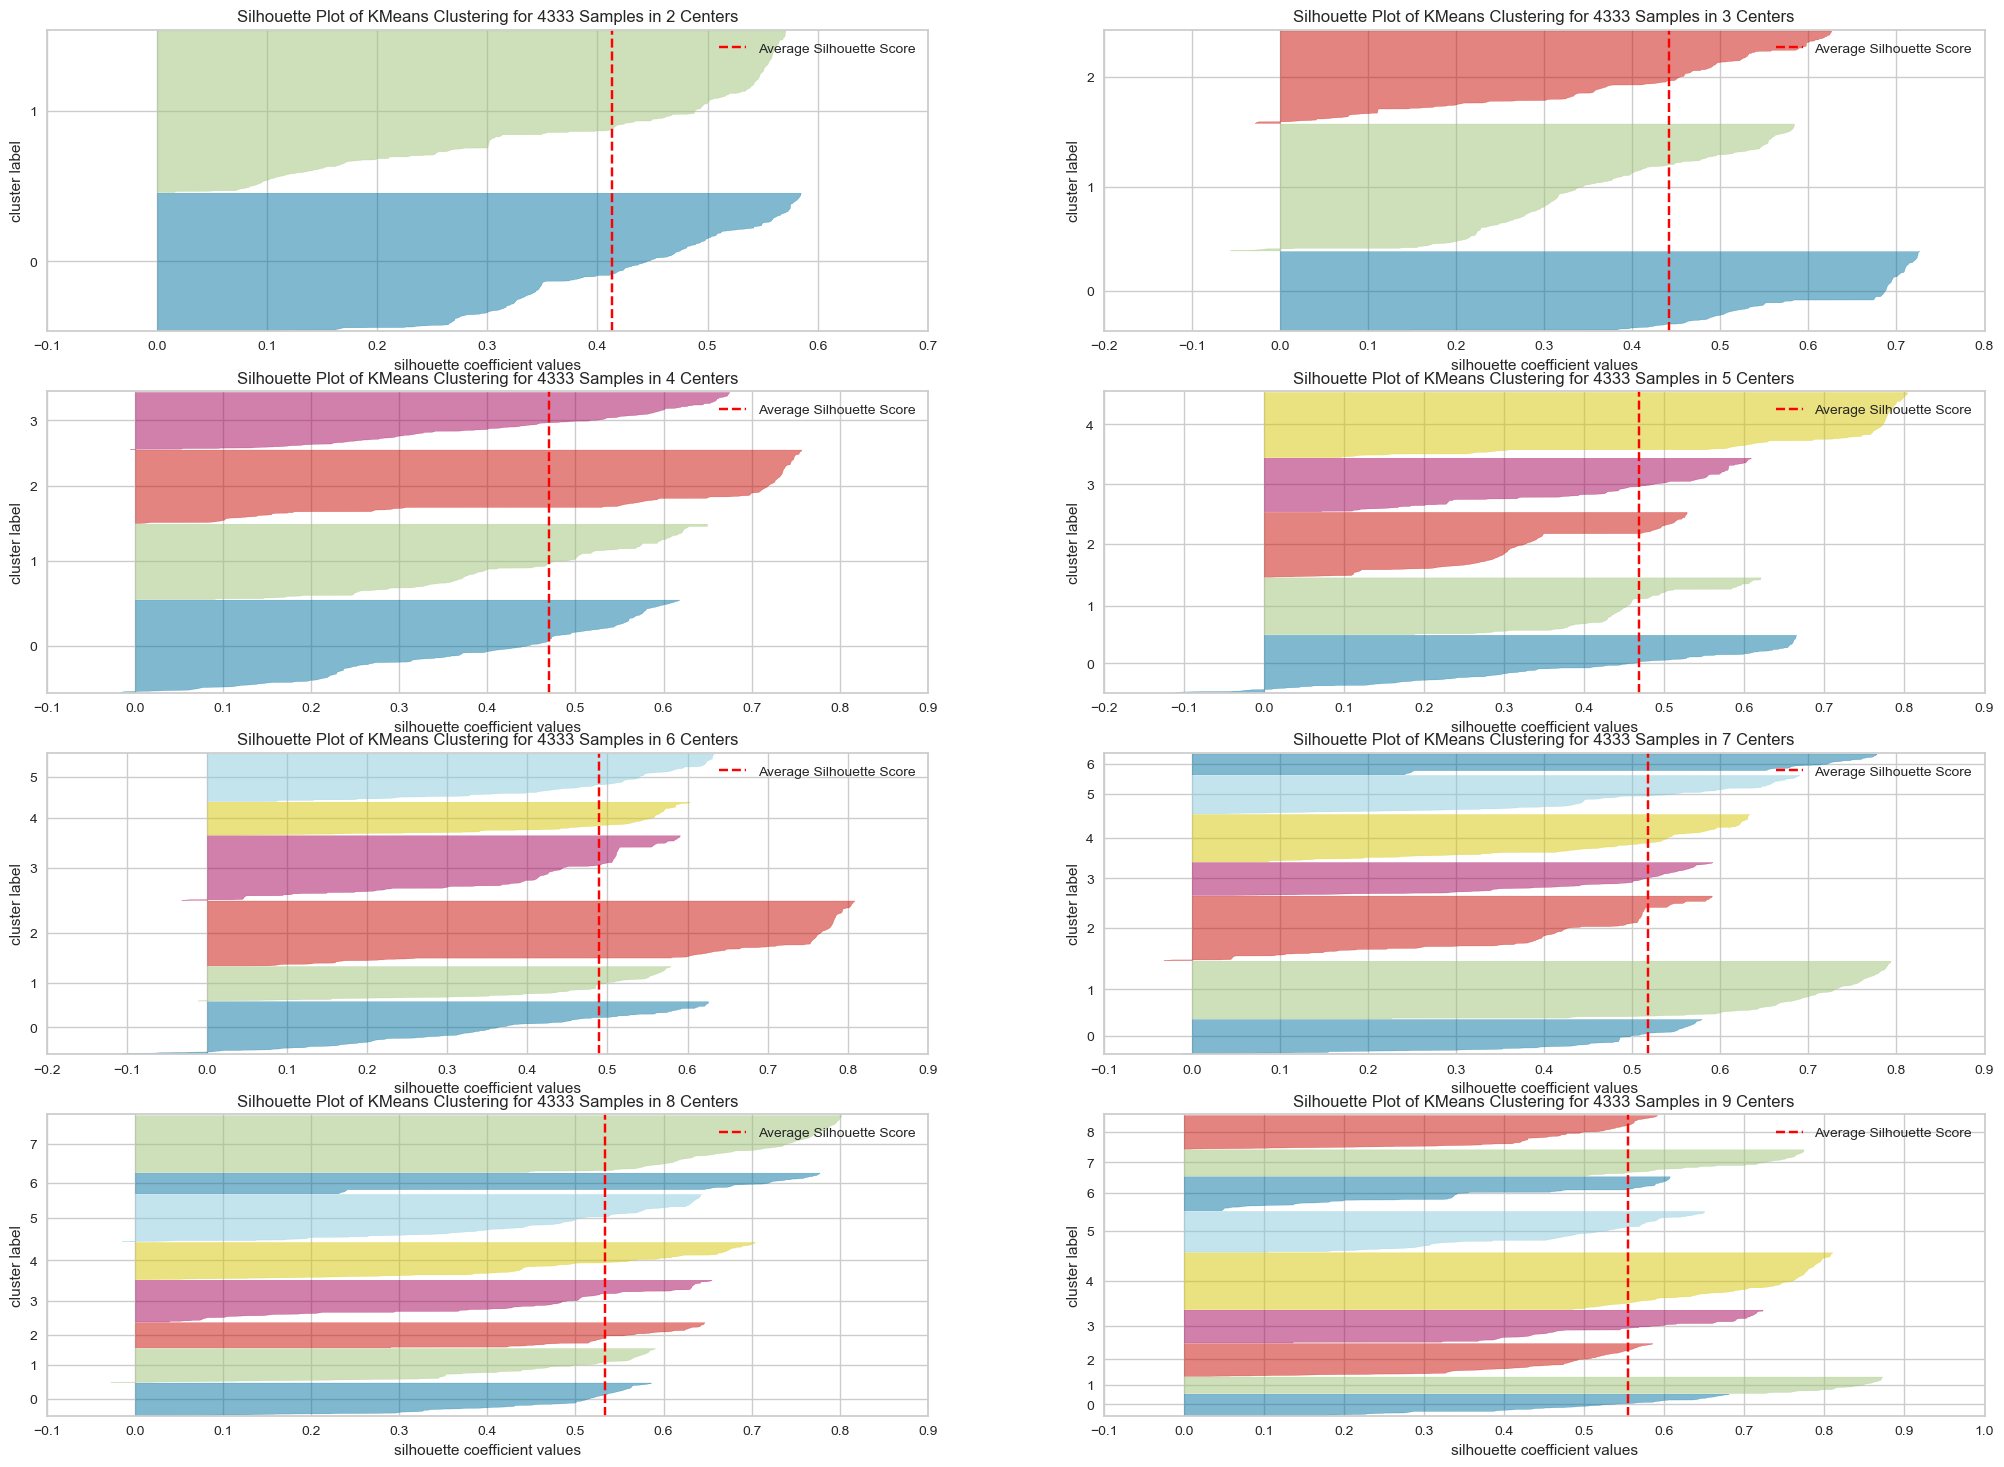

In [75]:
fig, ax = plt.subplots( 4, 2, figsize=(25, 18) )

for k in clusters:
    km = c.KMeans( n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42 )
    q, mod = divmod( k, 2 )
    
    visualizer = SilhouetteVisualizer( km, colors='yellowbrick', ax=ax[q-1][mod] )
    visualizer.fit( X )
    visualizer.finalize()

-----

-----

# 8.0 Model Training

## 8.1 K-Means

In [ ]:
# Model definition
k = 7 
kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, random_state=42, max_iter=300)

# model training
kmeans.fit(X)

# clustering
labels = kmeans.labels_

## 8.2 Cluster Validation

In [ ]:
# WSS (Within-cluster sum of square)
print(kmeans.inertia_)

# SS (Silhouette Score)
print(m.silhouette_score(X, labels, metric='euclidean'))

'''
kmeans.inertia_: Este é um atributo do objeto KMeans no sklearn que representa a soma dos quadrados intra-cluster, 
também conhecida como WSS (Within-cluster sum of square). O valor de inércia é uma métrica que indica a dispersão dos pontos dentro dos clusters. 
Quanto menor for o valor de inércia, mais compactos e bem definidos são os clusters. Este valor é uma medida útil para avaliar a qualidade do clustering, 
mas por si só não é suficiente para determinar o número ideal de clusters. Normalmente, o método do cotovelo (Elbow Method) é usado em conjunto com a 
inércia para encontrar o número ótimo de clusters.

m.silhouette_score(X, labels, metric='euclidean'): Aqui, você está calculando o escore de silhueta (Silhouette Score) usando a função silhouette_score
do módulo metrics do sklearn. O escore de silhueta é uma medida de quão semelhante um ponto de dados é ao seu próprio cluster (coesão) em comparação
com outros clusters (separação). Ele varia de -1 a 1, onde um valor mais próximo de 1 indica que o ponto está bem dentro do seu próprio cluster e
longe dos outros clusters, enquanto um valor mais próximo de -1 indica que o ponto está próximo ao limite de outro cluster. Um valor próximo de
0 indica que o ponto está próximo do limite entre dois clusters. Um escore de silhueta médio mais alto indica uma melhor separação entre os clusters.
O parâmetro metric='euclidean' especifica a métrica de distância a ser usada para calcular a silhueta (neste caso, a distância euclidiana).
'''

# 9.0 Cluster Analyslis

## 9.1 Visualization Inspection

## 9.2 Cluster Profile

# 10.0 Deploy